# 1. Konfiguracja początkowa

## 1.1 Instalacja potrzebnych pakietów

In [1]:
pip install rlcard torch numpy optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.0/269.0 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 kB 17.4 MB/s eta 0:00:00

# 2. Stworzenie sieci neuronowej

## 2.1 Importy

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random

from collections import deque

## 2.2 Klasa z pamięcią do przechowywania doświadczeń (bufor powtórek)

In [ ]:
class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen = capacity)

    def push(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

## 2.3 Klasa zawierająca sieć neuronową
- Funkcja aktywacji ReLU
- Warstwa wyjściowa podzielona na dwa strumienie

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, state_size, action_size, hidden_layers):
        super(NeuralNetwork, self).__init__()

        # Lista warstw
        layers = []

        input_size = state_size
        for hidden_layer in hidden_layers:
            layers.append(nn.Linear(input_size, hidden_layer))
            layers.append(nn.ReLU()) # Funkcja aktywacji po każdej warstwie
            input_size = hidden_layer

        # Połączenie utworzonych warstw
        self.created_layers = nn.Sequential(*layers)

        # Warstwy wyjściowe
        self.value_layer = nn.Sequential(nn.Linear(hidden_layers[-1], 1)) # Warstwa wartości

        self.advantage_layer = nn.Sequential(nn.Linear(hidden_layers[-1], action_size)) # Wartswa przewagi

    def forward(self, state):
        x = self.created_layers(state)

        value = self.value_layer(x)
        advantage = self.advantage_layer(x)

        a_max = advantage.max(dim = 1, keepdim = True).values
        q_values = value + (advantage - (1/torch.abs(advantage) * a_max))

        return q_values


## 2.4 Ustawienie ziarna losowości

In [ ]:
def set_seed(seed):
    torch.manual_seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    np.random.seed(seed)
    random.seed(seed)

set_seed(42)

# powtarzalne wyniki -> tensor([0.8823, 0.9150, 0.3829, 0.9593, 0.3904])
print(torch.rand(5))

tensor([0.8823, 0.9150, 0.3829, 0.9593, 0.3904])


# 3. Utworzenie Agenta Dueling DQN

## 3.1 Klasa zawierająca Agenta Dueling DQN

In [ ]:
class Agent_DuelingDQN:
    def __init__(self,
                 state_size,
                 action_size,
                 layers = [64, 64],
                 memory_size = 20000,
                 batch_size = 64,
                 lr = 0.001,
                 gamma = 0.99,
                 epsilon = 1.0,
                 epsilon_min = 0.1,
                 epsilon_decay = 0.995):

        self.state_size = state_size
        self.action_size = action_size
        self.batch_size = batch_size
        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.layers = layers

        # Bufor pamięci
        self.memory = ReplayMemory(memory_size)

        # Sieci neuronowe
        self.network = NeuralNetwork(state_size, action_size, layers)

        # Optymalizator
        self.optimizer = optim.Adam(self.network.parameters(), lr = lr)

        self.use_raw = False

    def step(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size) # Eksploracja
        else:
            state_tensor = torch.FloatTensor(state['obs']).unsqueeze(0)
            q_values = self.network(state_tensor).detach().numpy()
            return np.argmax(q_values) # Eksploatacja

    def remember(self, state, action, reward, next_state, done):
        self.memory.push(state, action, reward, next_state, done)

    def train(self):
        if len(self.memory) < self.batch_size:
            return

        batch = self.memory.sample(self.batch_size)

        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor([s['obs'] for s in states])
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor([s['obs'] for s in next_states])
        dones = torch.FloatTensor(dones)

        # Wartości Q dla bieżących stanów
        q_values = self.network(states)
        q_values = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)

        # Wartości Q dla następnych stanów
        with torch.no_grad():
            next_q_values = self.network(next_states).max(1)[0]
            target_q_values = rewards + self.gamma * next_q_values * (1 - dones)

        # Strata
        loss = nn.MSELoss()(q_values, target_q_values)

        # Optymalizacja
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Aktualizacja eksploracji
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def eval_step(self, state):
        state_tensor = torch.FloatTensor(state['obs']).unsqueeze(0)
        q_values = self.network(state_tensor).detach().numpy()
        return np.argmax(q_values), {}

# 4. Trenowanie agenta

## 4.1 Importy

In [ ]:
import rlcard
import matplotlib.pyplot as plt

from rlcard.agents import RandomAgent

## 4.1 Funkcja do testowania agenta podczas nauki

In [ ]:
def testing(env, episodes = 100):
    wins = 0
    for _ in range(episodes):
        trajectories, payoffs = env.run(is_training = False)
        if payoffs[0] > 0:
            wins += 1
    return wins / episodes

## 4.2 Funkcja do rysowania wykresu trenowania

In [ ]:
def diagram(percents, episodes):
    epis = list(range(0, episodes + 100, 100))

    plt.figure(figsize = (12,6))
    plt.plot(epis, percents, color = 'orange', label = 'Procent wygranych')
    plt.xlabel('Liczba epizodów')
    plt.ylabel('Procent wygranych gier (%)')
    plt.title("Wyniki agenta Dueling DQN w grze Limit Texas Hold'em - procent wygranych na przestrzeni epizodów")
    plt.ylim(0, 100)
    plt.grid(True)
    plt.legend()
    plt.show()

## 4.3 Funkcja do trenowania agenta
- `env` - Środowisko gry Limit Texas Hold'em z ustawionymi agentami
- `agent` - Agent którego chcemy uczyć
- `episodes` - Liczba epizodów przez które będzie trenowany agent

In [ ]:
def training_loop(env, agent, episodes):
    set_seed(42)

    num_of_episodes = episodes # Liczba epizodów do trenowania
    percent_of_wins = []

    for episode in range(num_of_episodes + 1):
        state, _ = env.reset()

        done = False
        while not done:
            action = agent.step(state)
            next_state, reward = env.step(action)
            done = env.is_over()
            agent.remember(state, action, reward, next_state, done)
            state = next_state

            agent.train()

        if episode % 100 == 0:
            win_rate = testing(env) * 100
            percent_of_wins.append(win_rate)
            print(f'Epizod {episode} zakończony. Win rate: {win_rate}%')

    print('Trenowanie zakończone.\n')
    diagram(percent_of_wins, num_of_episodes)

## 4.4 Trenowanie Agenta (Kroki powtarzane w eksperymentach)

### 4.4.1 Utworzenie agentów do treningu

In [ ]:
# utworzenie środowiska
env_0 = rlcard.make('limit-holdem', config={'seed': 42})

# agent losowy do nauki
random_agent = RandomAgent(num_actions = env_0.num_actions)

# agent Dueling_DQN, który będzie się uczyć
agent_0 = Agent_DuelingDQN(state_size = env_0.state_shape[0][0], action_size = env_0.num_actions)

# ustawienie agentów w środowisku
env_0.set_agents([agent_0, random_agent])

# wypisanie agentów
print(f'Agenci: {env_0.agents}')

Agenci: [<__main__.Agent_DuelingDQN object at 0x7b1b289bc050>, <rlcard.agents.random_agent.RandomAgent object at 0x7b1b2b76a750>]


### 4.4.2 Uruchomienie pętli treningowej
### ! Pomijane w przypadku wczytania modelu z pliku zewnętrznego


Epizod 0 zakończony. Win rate: 39.0%
Epizod 100 zakończony. Win rate: 90.0%
Epizod 200 zakończony. Win rate: 87.0%
Epizod 300 zakończony. Win rate: 91.0%
Epizod 400 zakończony. Win rate: 91.0%
Epizod 500 zakończony. Win rate: 86.0%
Epizod 600 zakończony. Win rate: 94.0%
Epizod 700 zakończony. Win rate: 95.0%
Epizod 800 zakończony. Win rate: 91.0%
Epizod 900 zakończony. Win rate: 94.0%
Epizod 1000 zakończony. Win rate: 95.0%
Epizod 1100 zakończony. Win rate: 88.0%
Epizod 1200 zakończony. Win rate: 91.0%
Epizod 1300 zakończony. Win rate: 94.0%
Epizod 1400 zakończony. Win rate: 80.0%
Epizod 1500 zakończony. Win rate: 99.0%
Epizod 1600 zakończony. Win rate: 94.0%
Epizod 1700 zakończony. Win rate: 95.0%
Epizod 1800 zakończony. Win rate: 93.0%
Epizod 1900 zakończony. Win rate: 96.0%
Epizod 2000 zakończony. Win rate: 96.0%
Epizod 2100 zakończony. Win rate: 88.0%
Epizod 2200 zakończony. Win rate: 94.0%
Epizod 2300 zakończony. Win rate: 95.0%
Epizod 2400 zakończony. Win rate: 94.0%
Epizod 2500 

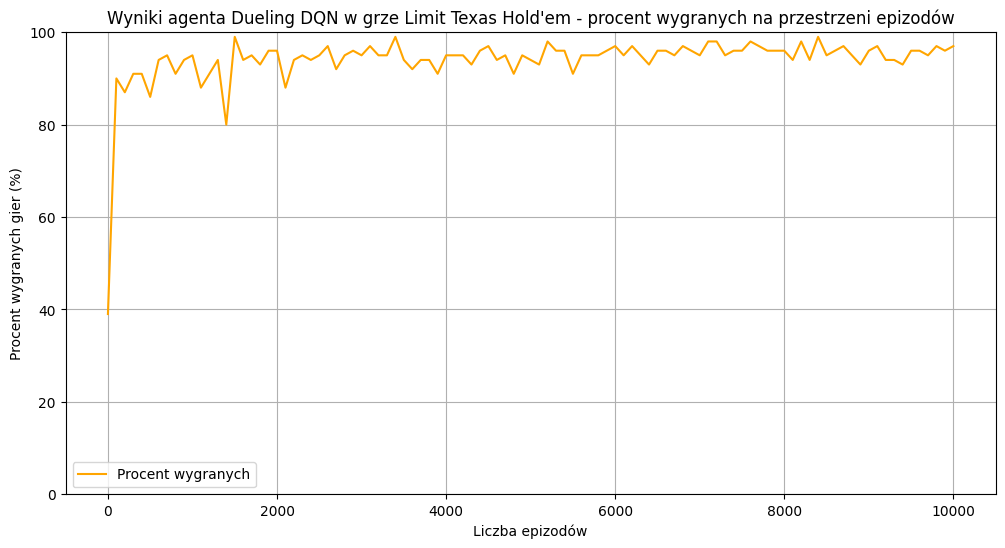

In [ ]:
training_loop(env_0, agent_0, 10000)

## 4.5 Zapis i wczytanie modelu *

### 4.5.1 Zapisanie modelu do pliku zewnętrznego
### ! Pomijane w przypadku wczytania modelu z pliku zewnętrznego

In [ ]:
torch.save(agent_0.network.state_dict(), 'dueling_agent_0_model.pth')

### 4.5.2 Wczytanie modelu z pliku zewnętrznego*

In [ ]:
agent_0.network.load_state_dict(torch.load('dueling_agent_0_model.pth'))

<ipython-input-13-b4cc61683a0b>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  agent_0.network.load_state_dict(torch.load('dueling_agent_0_model.pth'))


<All keys matched successfully>

# 5. Funkcja do testowania agentów

In [ ]:
def experiment(env):
    games = 1000
    total_reward = 0
    wins = 0

    for game in range(games):
        trajectories, payoffs = env.run(is_training = False)
        total_reward += payoffs[0]
        if payoffs[0] > payoffs[1]:
            wins += 1

    print(f'Agent po rozegraniu {games} gier uzyskał następujące wyniki:\n')
    print(f'Agent wygrał: {(wins / games)* 100}% gier.')
    print(f'Średnia nagroda agenta na grę wyniosła: {total_reward / games}.')

## 5.1 Testowanie agenta



In [ ]:
env_test = rlcard.make('limit-holdem', config={'seed': 42})

env_test.set_agents([agent_0, random_agent])

print("Test agent_0 vs random_agent")

experiment(env_test)

Test agent_0 vs random_agent
Agent po rozegraniu 1000 gier uzyskał następujące wyniki:

Agent wygrał: 96.6% gier.
Średnia nagroda agenta na grę wyniosła: 2.5995.


### Wyniki

> # Test:
> Agent wygrał ~96.6% gier z średnią nagrodą 2.5995

# 6. Eksperymenty:

- ETAP I - 2 warstwy:
  - **agent_0**: warstwy [64, 64] trenowany na agencie random (10k epizodów), lr = 0.001
     - agent_0 jest agentem. który jest domyślnie tworzony, bez podania konkretnych hiperparametrów
  - **agent_1**: warstwy [128, 128] trenowany na agencie random (10k epizodów), lr = 0.001
  - **agent_2**: warstwy [256, 256] trenowany na agencie random (10k epizodów), lr = 0.001
  - **agent_3**: warstwy [512, 512] trenowany na agencie random (10k epizodów), lr = 0.001
  - **agent_4**: warstwy [32, 32] trenowany na agencie random (10k epizodów), lr = 0.001
  - **agent_5**: agent_0 z zmniejszonym learning rate, lr = 0.0001
  - **agent_6**: agent który uzyskał najlepsze wyniki do tej pory (50k epizodów)

- ETAP II - 3 warstwy:
  - **agent_7**: warstwy [64, 64, 64] trenowany na agencie random (10k epizodów), lr = 0.001
  - **agent_8**: warstwy [128, 128, 128] trenowany na agencie random (10k epizodów), lr = 0.001
  - **agent_9**: warstwy [256, 256, 256] trenowany na agencie random (10k epizodów), lr = 0.001
  - **agent_10**: warstwy [512, 512, 512] trenowany na agencie random (10k epizodów), lr = 0.001
  - **agent_11**: najlepszy agent z zmniejszonym learning rate, , lr = 0.0001

- ETAP III - nauka na innym agencie
  - **agent_12**: ***najlepszy agent z ETAP I*** trenowany na ***najlepszym agencie z ETAP I*** (liczba epizodów 10k)
  - **agent_13**: ***najlepszy agent z ETAP II*** trenowany na ***najlepszym agencie z ETAP I*** (liczba epizodów 10k)
  - **agent_14**: ***najlepszy agent z ETAP II*** trenowany na ***najlepszym agencie z ETAP II*** (liczba epizodów 10k)
  - **agent_15**: ***najlepszy agent z ETAP I*** trenowany na ***najlepszym agencie z ETAP II*** (liczba epizodów 10k)

- ETAP IV - dobór hiperparametrów za pomocą biblioteki Optuna
  - wybór trzech najlepszych zestawów hiperparametrów dla agentów za pomocą biblioteki Optuna na podstawie 100 epizodów treningowych
  - przetrenowanie najlepszych agentów na 10k epizodów na agencie random
    - **agent_optuna_1**
    - **agent_optuna_2**
    - **agent_optuna_3**

- ETAP V - testowanie najlepszych agentów vs wbudowany agent ze środowiska RLCard
  - przetrenowanie agenta DQN ze środowiska RLCard
  - pojedynki agentów


> Testy w eksperymentach będą przeprowadzane na zasadzie:
  - agent A vs agent B => zwycięzca pojedunku I
  - agent C vs zwycięzca pojedunku I => zwycięzca pojedynku II
  - itd...

> np.
  - agent[128, 128] vs agent[256, 256] => lepszy agent[256, 256]
  - agent[512, 512] vs agent[256, 256] => lepszy agent[256, 256]
  - agent[128, 128, 128] vs agent[256, 256] => ...

## ETAP I - 2 warstwy

> - Znalezienie najlepszego agenta z dwoma warstwami ukrytymi sieci neuronowej
- Sprawdzenie czy agent osiąga lepsze wyniki gdy jest trenowany na większej liczbie epizodów


### Eksperyment 1.1 - [128, 128] vs Random
# ***Agent_1***
Dueling_DQN:
  - warstwy ukryte: **dwie warstwy po 128 neuronów**
  - liczba epizodów: **10 tysięcy**
  - learning rate: **0.001**

Utworzenie środowiska i agentów

In [ ]:
# utworzenie środowiska
env_1 = rlcard.make('limit-holdem', config={'seed': 42})

# agent losowy do nauki
random_agent = RandomAgent(num_actions = env_1.num_actions)

# agent Dueling_DQN, który będzie się uczyć
agent_1 = Agent_DuelingDQN(state_size = env_1.state_shape[0][0], action_size = env_1.num_actions, layers = [128, 128], lr = 0.001)

# ustawienie agentów w środowisku
env_1.set_agents([agent_1, random_agent])

# wypisanie agentów
print(f'Agenci: {env_1.agents}')

Agenci: [<__main__.Agent_DuelingDQN object at 0x7c75e0275d90>, <rlcard.agents.random_agent.RandomAgent object at 0x7c74f5d2a1d0>]


Uruchomienie pętli treningowej

Epizod 0 zakończony. Win rate: 46.0%


<ipython-input-6-3d3d5e929d27>:54: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  states = torch.FloatTensor([s['obs'] for s in states])


Epizod 100 zakończony. Win rate: 82.0%
Epizod 200 zakończony. Win rate: 87.0%
Epizod 300 zakończony. Win rate: 93.0%
Epizod 400 zakończony. Win rate: 78.0%
Epizod 500 zakończony. Win rate: 90.0%
Epizod 600 zakończony. Win rate: 93.0%
Epizod 700 zakończony. Win rate: 91.0%
Epizod 800 zakończony. Win rate: 92.0%
Epizod 900 zakończony. Win rate: 89.0%
Epizod 1000 zakończony. Win rate: 93.0%
Epizod 1100 zakończony. Win rate: 92.0%
Epizod 1200 zakończony. Win rate: 98.0%
Epizod 1300 zakończony. Win rate: 90.0%
Epizod 1400 zakończony. Win rate: 96.0%
Epizod 1500 zakończony. Win rate: 91.0%
Epizod 1600 zakończony. Win rate: 96.0%
Epizod 1700 zakończony. Win rate: 97.0%
Epizod 1800 zakończony. Win rate: 93.0%
Epizod 1900 zakończony. Win rate: 91.0%
Epizod 2000 zakończony. Win rate: 94.0%
Epizod 2100 zakończony. Win rate: 93.0%
Epizod 2200 zakończony. Win rate: 94.0%
Epizod 2300 zakończony. Win rate: 97.0%
Epizod 2400 zakończony. Win rate: 91.0%
Epizod 2500 zakończony. Win rate: 92.0%
Epizod 26

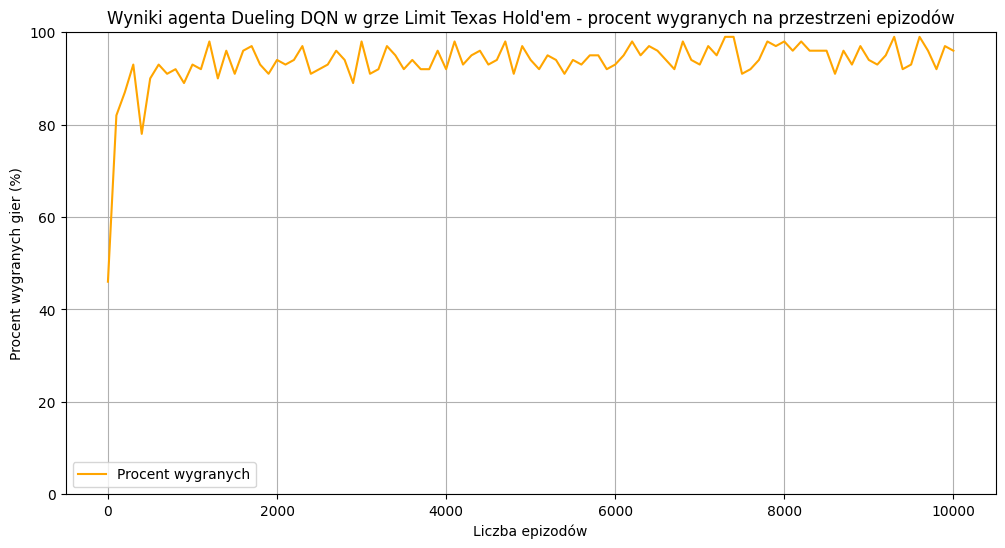

In [ ]:
# uruchomienie pętli treningowej
training_loop(env_1, agent_1, 10000)

Zapisanie i wczytanie modelu


In [ ]:
# zapisanie modelu do pliku zewnętrznego
torch.save(agent_1.network.state_dict(), 'dueling_agent_1_model.pth')

In [ ]:
# wczytanie modelu z zewnętrznego pliku
agent_1.network.load_state_dict(torch.load('dueling_agent_1_model.pth'))

<ipython-input-22-ae986a7c1eda>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  agent_1.network.load_state_dict(torch.load('dueling_agent_1_model.pth'))


<All keys matched successfully>

Test przeciwko agentowi_0

> agent_0 - agent przykładowy:
  - warstwy ukryte: dwie warstwy po 64 neurony
  - liczba epizodów: 10 tysięcy
  - learning rate: 0.001
  

In [ ]:
env1_test = rlcard.make('limit-holdem', config={'seed': 42})
env1_test.set_agents([agent_1, agent_0])

print("Test agent_1 vs agent_0")

experiment(env1_test)

Test agent_1 vs agent_0
Agent po rozegraniu 1000 gier uzyskał następujące wyniki:

Agent wygrał: 39.1% gier.
Średnia nagroda agenta na grę wyniosła: -3.216.


> Agent wygrał 39.1% gier z średnią nagrodą -3.216

### Eksperyment 1.2 - [256, 256] vs Random
# ***Agent_2***
Dueling_DQN:
  - warstwy ukryte: **dwie warstwy po 256 neuronów**
  - liczba epizodów: **10 tysięcy**
  - learning rate: **0.001**

Utworzenie środowiska i agentów

In [ ]:
# utworzenie środowiska
env_2 = rlcard.make('limit-holdem', config={'seed': 42})

# agent losowy do nauki
random_agent = RandomAgent(num_actions = env_2.num_actions)

# agent Dueling_DQN, który będzie się uczyć
agent_2 = Agent_DuelingDQN(state_size = env_2.state_shape[0][0], action_size = env_2.num_actions, layers = [256, 256], lr = 0.001)

# ustawienie agentów w środowisku
env_2.set_agents([agent_2, random_agent])

# wypisanie agentów
print(f'Agenci: {env_2.agents}')

Agenci: [<__main__.Agent_DuelingDQN object at 0x7c74f1d77490>, <rlcard.agents.random_agent.RandomAgent object at 0x7c74f1538bd0>]


Uruchomienie pętli treningowej

Epizod 0 zakończony. Win rate: 48.0%
Epizod 100 zakończony. Win rate: 87.0%
Epizod 200 zakończony. Win rate: 87.0%
Epizod 300 zakończony. Win rate: 93.0%
Epizod 400 zakończony. Win rate: 88.0%
Epizod 500 zakończony. Win rate: 91.0%
Epizod 600 zakończony. Win rate: 98.0%
Epizod 700 zakończony. Win rate: 96.0%
Epizod 800 zakończony. Win rate: 92.0%
Epizod 900 zakończony. Win rate: 93.0%
Epizod 1000 zakończony. Win rate: 92.0%
Epizod 1100 zakończony. Win rate: 97.0%
Epizod 1200 zakończony. Win rate: 99.0%
Epizod 1300 zakończony. Win rate: 95.0%
Epizod 1400 zakończony. Win rate: 97.0%
Epizod 1500 zakończony. Win rate: 96.0%
Epizod 1600 zakończony. Win rate: 96.0%
Epizod 1700 zakończony. Win rate: 93.0%
Epizod 1800 zakończony. Win rate: 90.0%
Epizod 1900 zakończony. Win rate: 93.0%
Epizod 2000 zakończony. Win rate: 98.0%
Epizod 2100 zakończony. Win rate: 94.0%
Epizod 2200 zakończony. Win rate: 95.0%
Epizod 2300 zakończony. Win rate: 93.0%
Epizod 2400 zakończony. Win rate: 93.0%
Epizod 2500 

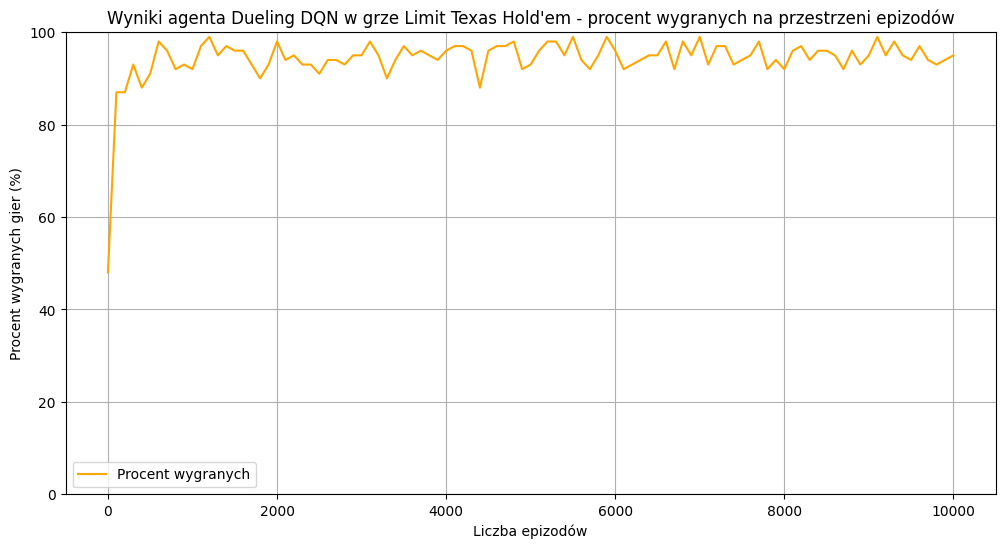

In [ ]:
# uruchomienie pętli treningowej
training_loop(env_2, agent_2, 10000)

Zapisanie i wczytanie modelu


In [ ]:
# zapisanie modelu do pliku zewnętrznego
torch.save(agent_2.network.state_dict(), 'dueling_agent_2_model.pth')

In [ ]:
# wczytanie modelu z zewnętrznego pliku
agent_2.network.load_state_dict(torch.load('dueling_agent_2_model.pth'))

<ipython-input-44-29d31549132f>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  agent_2.network.load_state_dict(torch.load('dueling_agent_2_model.pth'))


<All keys matched successfully>

Test przeciwko agentowi_0

> agent_0 - zwycięzca z *agent_1* vs *agent_0*:
  - warstwy ukryte: **dwie warstwy po 64 neurony**
  - liczba epizodów: **10 tysięcy**
  - learning rate: **0.001**
  

In [ ]:
env2_test = rlcard.make('limit-holdem', config={'seed': 42})
env2_test.set_agents([agent_2, agent_0])

print("Test agent_2 vs agent_0")

experiment(env2_test)

Test agent_2 vs agent_0
Agent po rozegraniu 1000 gier uzyskał następujące wyniki:

Agent wygrał: 46.2% gier.
Średnia nagroda agenta na grę wyniosła: -0.59.


> Agent_2 wygrał 46.2% gier ze średnią nagrodą -0.59


### Eksperyment 1.3 - [512, 512] vs Random
# ***Agent_3***
Dueling_DQN:
  - warstwy ukryte: **dwie warstwy po 512 neuronów**
  - liczba epizodów: **10 tysięcy**
  - learning rate: **0.001**

Utworzenie środowiska i agentów

In [ ]:
# utworzenie środowiska
env_3 = rlcard.make('limit-holdem', config={'seed': 42})

# agent losowy do nauki
random_agent = RandomAgent(num_actions = env_3.num_actions)

# agent Dueling_DQN, który będzie się uczyć
agent_3 = Agent_DuelingDQN(state_size = env_3.state_shape[0][0], action_size = env_3.num_actions, layers = [512, 512], lr = 0.001)

# ustawienie agentów w środowisku
env_3.set_agents([agent_3, random_agent])

# wypisanie agentów
print(f'Agenci: {env_3.agents}')

Agenci: [<__main__.Agent_DuelingDQN object at 0x7c74ee9e9110>, <rlcard.agents.random_agent.RandomAgent object at 0x7c74ee602550>]


Uruchomienie pętli treningowej

Epizod 0 zakończony. Win rate: 43.0%
Epizod 100 zakończony. Win rate: 90.0%
Epizod 200 zakończony. Win rate: 81.0%
Epizod 300 zakończony. Win rate: 92.0%
Epizod 400 zakończony. Win rate: 74.0%
Epizod 500 zakończony. Win rate: 67.0%
Epizod 600 zakończony. Win rate: 61.0%
Epizod 700 zakończony. Win rate: 59.0%
Epizod 800 zakończony. Win rate: 63.0%
Epizod 900 zakończony. Win rate: 66.0%
Epizod 1000 zakończony. Win rate: 71.0%
Epizod 1100 zakończony. Win rate: 82.0%
Epizod 1200 zakończony. Win rate: 79.0%
Epizod 1300 zakończony. Win rate: 77.0%
Epizod 1400 zakończony. Win rate: 80.0%
Epizod 1500 zakończony. Win rate: 81.0%
Epizod 1600 zakończony. Win rate: 73.0%
Epizod 1700 zakończony. Win rate: 73.0%
Epizod 1800 zakończony. Win rate: 74.0%
Epizod 1900 zakończony. Win rate: 86.0%
Epizod 2000 zakończony. Win rate: 86.0%
Epizod 2100 zakończony. Win rate: 81.0%
Epizod 2200 zakończony. Win rate: 85.0%
Epizod 2300 zakończony. Win rate: 48.0%
Epizod 2400 zakończony. Win rate: 59.0%
Epizod 2500 

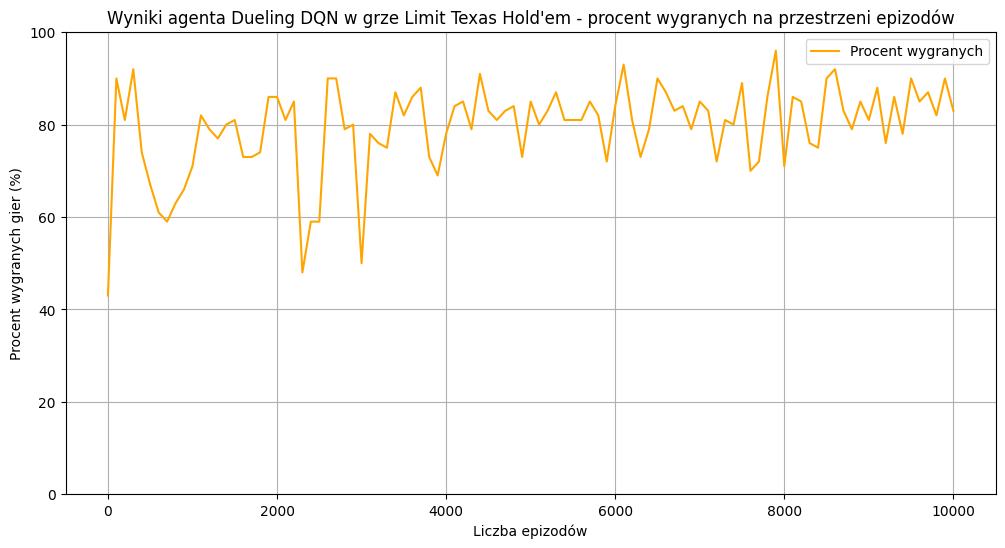

In [ ]:
# uruchomienie pętli treningowej
training_loop(env_3, agent_3, 10000)

Zapisanie i wczytanie modelu


In [ ]:
# zapisanie modelu do pliku zewnętrznego
torch.save(agent_3.network.state_dict(), 'dueling_agent_3_model.pth')

In [ ]:
# wczytanie modelu z zewnętrznego pliku
agent_3.network.load_state_dict(torch.load('dueling_agent_3_model.pth'))

<ipython-input-64-bd1244be27d1>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  agent_3.network.load_state_dict(torch.load('dueling_agent_3_model.pth'))


<All keys matched successfully>

Test przeciwko agentowi_0

> agent_0 - zwycięzca z *agent_2* vs *agent_0*:
  - warstwy ukryte: **dwie warstwy po 64 neurony**
  - liczba epizodów: **10 tysięcy**
  - learning rate: **0.001**
  

In [ ]:
env3_test = rlcard.make('limit-holdem', config={'seed': 42})
env3_test.set_agents([agent_3, agent_0])

print("Test agent_3 vs agent_0")

experiment(env3_test)

Test agent_3 vs agent_0
Agent po rozegraniu 1000 gier uzyskał następujące wyniki:

Agent wygrał: 23.799999999999997% gier.
Średnia nagroda agenta na grę wyniosła: -3.5405.


> Agent_3 wygrał 23.79% gier ze średnią nagrodą -3.5405


### Eksperyment 1.4 - [32, 32] vs Random

# ***Agent_4***
Dueling_DQN:
  - warstwy ukryte: **dwie warstwy po 32 neurony**
  - liczba epizodów: **10 tysięcy**
  - learning rate: **0.001**

Utworzenie środowiska i agentów

In [ ]:
# utworzenie środowiska
env_4 = rlcard.make('limit-holdem', config={'seed': 42})

# agent losowy do nauki
random_agent = RandomAgent(num_actions = env_4.num_actions)

# agent Dueling_DQN, który będzie się uczyć
agent_4 = Agent_DuelingDQN(state_size = env_4.state_shape[0][0], action_size = env_4.num_actions, layers = [32, 32], lr = 0.001)

# ustawienie agentów w środowisku
env_4.set_agents([agent_4, random_agent])

# wypisanie agentów
print(f'Agenci: {env_4.agents}')

Agenci: [<__main__.Agent_DuelingDQN object at 0x7c74eafea710>, <rlcard.agents.random_agent.RandomAgent object at 0x7c74ec0709d0>]


Uruchomienie pętli treningowej

Epizod 0 zakończony. Win rate: 24.0%
Epizod 100 zakończony. Win rate: 74.0%
Epizod 200 zakończony. Win rate: 86.0%
Epizod 300 zakończony. Win rate: 83.0%
Epizod 400 zakończony. Win rate: 87.0%
Epizod 500 zakończony. Win rate: 80.0%
Epizod 600 zakończony. Win rate: 88.0%
Epizod 700 zakończony. Win rate: 84.0%
Epizod 800 zakończony. Win rate: 88.0%
Epizod 900 zakończony. Win rate: 90.0%
Epizod 1000 zakończony. Win rate: 75.0%
Epizod 1100 zakończony. Win rate: 77.0%
Epizod 1200 zakończony. Win rate: 82.0%
Epizod 1300 zakończony. Win rate: 83.0%
Epizod 1400 zakończony. Win rate: 84.0%
Epizod 1500 zakończony. Win rate: 88.0%
Epizod 1600 zakończony. Win rate: 87.0%
Epizod 1700 zakończony. Win rate: 83.0%
Epizod 1800 zakończony. Win rate: 92.0%
Epizod 1900 zakończony. Win rate: 89.0%
Epizod 2000 zakończony. Win rate: 91.0%
Epizod 2100 zakończony. Win rate: 88.0%
Epizod 2200 zakończony. Win rate: 96.0%
Epizod 2300 zakończony. Win rate: 95.0%
Epizod 2400 zakończony. Win rate: 95.0%
Epizod 2500 

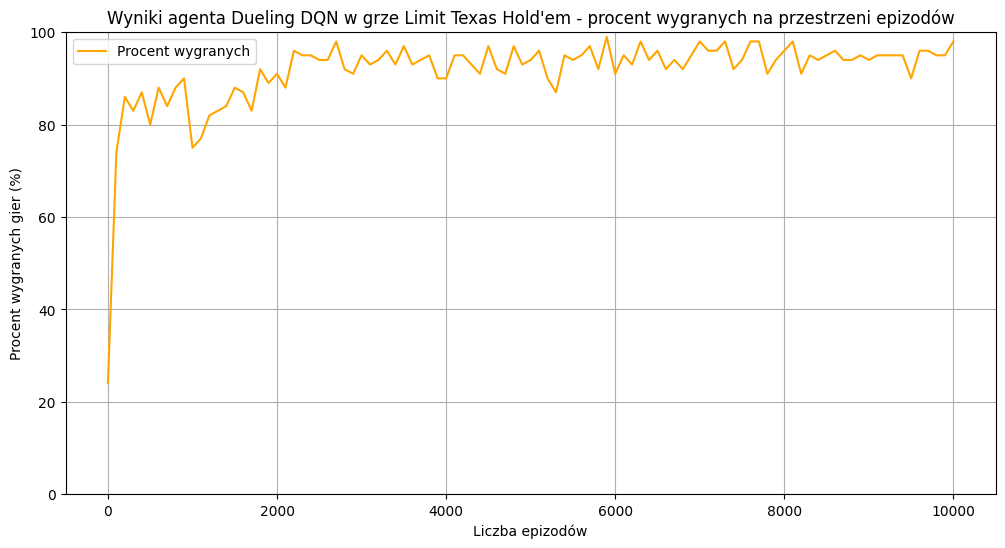

In [ ]:
# uruchomienie pętli treningowej
training_loop(env_4, agent_4, 10000)

Zapisanie i wczytanie modelu


In [ ]:
# zapisanie modelu do pliku zewnętrznego
torch.save(agent_4.network.state_dict(), 'dueling_agent_4_model.pth')

In [ ]:
# wczytanie modelu z zewnętrznego pliku
agent_4.network.load_state_dict(torch.load('dueling_agent_4_model.pth'))

<ipython-input-64-bd1244be27d1>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  agent_3.network.load_state_dict(torch.load('dueling_agent_3_model.pth'))


<All keys matched successfully>

Test przeciwko agentowi_0

> agent_0 - zwycięzca z *agent_3* vs *agent_0*:
  - warstwy ukryte: **dwie warstwy po 64 neurony**
  - liczba epizodów: **10 tysięcy**
  - learning rate: **0.001**
  

In [ ]:
env4_test = rlcard.make('limit-holdem', config={'seed': 42})
env4_test.set_agents([agent_4, agent_0])

print("Test agent_4 vs agent_0")

experiment(env4_test)

Test agent_4 vs agent_0
Agent po rozegraniu 1000 gier uzyskał następujące wyniki:

Agent wygrał: 49.3% gier.
Średnia nagroda agenta na grę wyniosła: 0.362.


> Agent_4 wygrał 49.3% gier ze średnią nagrodą 0.362


### Eksperyment 1.5 - [64, 64] vs Random
(zmniejszenie learning rate

# ***Agent_5***
Dueling_DQN:
  - warstwy ukryte: **dwie warstwy po 64 neurony**
  - liczba epizodów: **10 tysięcy**
  - learning rate: **0.0001**

Utworzenie środowiska i agentów

In [ ]:
# utworzenie środowiska
env_5 = rlcard.make('limit-holdem', config={'seed': 42})

# agent losowy do nauki
random_agent = RandomAgent(num_actions = env_5.num_actions)

# agent Dueling_DQN, który będzie się uczyć
agent_5 = Agent_DuelingDQN(state_size = env_5.state_shape[0][0], action_size = env_5.num_actions, layers = [64, 64], lr = 0.0001)

# ustawienie agentów w środowisku
env_5.set_agents([agent_5, random_agent])

# wypisanie agentów
print(f'Agenci: {env_5.agents}')

Agenci: [<__main__.Agent_DuelingDQN object at 0x7fcd45f65de0>, <rlcard.agents.random_agent.RandomAgent object at 0x7fcd45f67a00>]


Uruchomienie pętli treningowej

Epizod 0 zakończony. Win rate: 45.0%
Epizod 100 zakończony. Win rate: 80.0%
Epizod 200 zakończony. Win rate: 78.0%
Epizod 300 zakończony. Win rate: 79.0%
Epizod 400 zakończony. Win rate: 85.0%
Epizod 500 zakończony. Win rate: 89.0%
Epizod 600 zakończony. Win rate: 92.0%
Epizod 700 zakończony. Win rate: 92.0%
Epizod 800 zakończony. Win rate: 96.0%
Epizod 900 zakończony. Win rate: 91.0%
Epizod 1000 zakończony. Win rate: 93.0%
Epizod 1100 zakończony. Win rate: 96.0%
Epizod 1200 zakończony. Win rate: 90.0%
Epizod 1300 zakończony. Win rate: 93.0%
Epizod 1400 zakończony. Win rate: 96.0%
Epizod 1500 zakończony. Win rate: 96.0%
Epizod 1600 zakończony. Win rate: 89.0%
Epizod 1700 zakończony. Win rate: 87.0%
Epizod 1800 zakończony. Win rate: 91.0%
Epizod 1900 zakończony. Win rate: 97.0%
Epizod 2000 zakończony. Win rate: 89.0%
Epizod 2100 zakończony. Win rate: 91.0%
Epizod 2200 zakończony. Win rate: 92.0%
Epizod 2300 zakończony. Win rate: 88.0%
Epizod 2400 zakończony. Win rate: 89.0%
Epizod 2500 

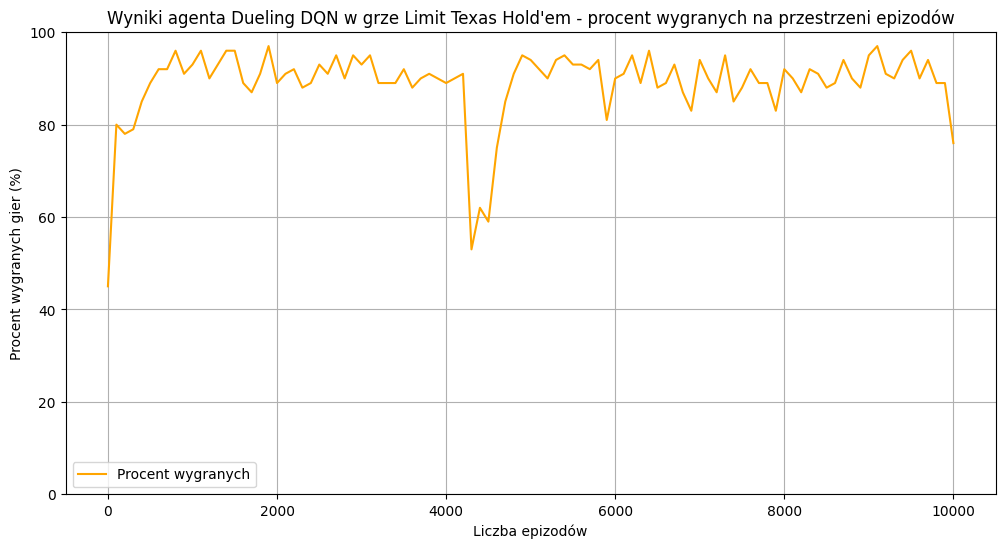

In [ ]:
# uruchomienie pętli treningowej
training_loop(env_5, agent_5, 10000)

Zapisanie i wczytanie modelu


In [ ]:
# zapisanie modelu do pliku zewnętrznego
torch.save(agent_5.network.state_dict(), 'dueling_agent_5_model.pth')

In [ ]:
# wczytanie modelu z zewnętrznego pliku
agent_5.network.load_state_dict(torch.load('dueling_agent_5_model.pth'))

<ipython-input-64-bd1244be27d1>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  agent_3.network.load_state_dict(torch.load('dueling_agent_3_model.pth'))


<All keys matched successfully>

Test przeciwko agentowi_0

> agent_0 - zwycięzca z *agent_4* vs *agent_0*:
  - warstwy ukryte: **dwie warstwy po 64 neurony**
  - liczba epizodów: **10 tysięcy**
  - learning rate: **0.001**
  

In [ ]:
env5_test = rlcard.make('limit-holdem', config={'seed': 42})
env5_test.set_agents([agent_5, agent_0])

print("Test agent_5 vs agent_0")

experiment(env5_test)

Test agent_5 vs agent_0
Agent po rozegraniu 1000 gier uzyskał następujące wyniki:

Agent wygrał: 34.0% gier.
Średnia nagroda agenta na grę wyniosła: -2.306.


> Agent_5 wygrał 34.0% gier ze średnią nagrodą -2.306


### Eksperyment 1.6 - [64, 64] vs Random
(agent_0 + zwiększenie epizodów podczas nauki)

# ***Agent_6***
Dueling_DQN:
  - warstwy ukryte: **dwie warstwy po 64 neurony**
  - liczba epizodów: **50 tysięcy**
  - learning rate: **0.001**

Utworzenie środowiska i agentów

In [ ]:
# utworzenie środowiska
env_6 = rlcard.make('limit-holdem', config={'seed': 42})

# agent losowy do nauki
random_agent = RandomAgent(num_actions = env_6.num_actions)

# agent Dueling_DQN, który będzie się uczyć
agent_6 = Agent_DuelingDQN(state_size = env_6.state_shape[0][0], action_size = env_6.num_actions)

# ustawienie agentów w środowisku
env_6.set_agents([agent_6, random_agent])

# wypisanie agentów
print(f'Agenci: {env_6.agents}')

Agenci: [<__main__.Agent_DuelingDQN object at 0x7fcd45a37bb0>, <rlcard.agents.random_agent.RandomAgent object at 0x7fcd45b45ff0>]


Uruchomienie pętli treningowej

Epizod 0 zakończony. Win rate: 10.0%
Epizod 100 zakończony. Win rate: 41.0%
Epizod 200 zakończony. Win rate: 93.0%
Epizod 300 zakończony. Win rate: 48.0%
Epizod 400 zakończony. Win rate: 83.0%
Epizod 500 zakończony. Win rate: 89.0%
Epizod 600 zakończony. Win rate: 89.0%
Epizod 700 zakończony. Win rate: 78.0%
Epizod 800 zakończony. Win rate: 86.0%
Epizod 900 zakończony. Win rate: 90.0%
Epizod 1000 zakończony. Win rate: 85.0%
Epizod 1100 zakończony. Win rate: 89.0%
Epizod 1200 zakończony. Win rate: 85.0%
Epizod 1300 zakończony. Win rate: 83.0%
Epizod 1400 zakończony. Win rate: 81.0%
Epizod 1500 zakończony. Win rate: 88.0%
Epizod 1600 zakończony. Win rate: 90.0%
Epizod 1700 zakończony. Win rate: 85.0%
Epizod 1800 zakończony. Win rate: 94.0%
Epizod 1900 zakończony. Win rate: 72.0%
Epizod 2000 zakończony. Win rate: 84.0%
Epizod 2100 zakończony. Win rate: 92.0%
Epizod 2200 zakończony. Win rate: 87.0%
Epizod 2300 zakończony. Win rate: 87.0%
Epizod 2400 zakończony. Win rate: 92.0%
Epizod 2500 

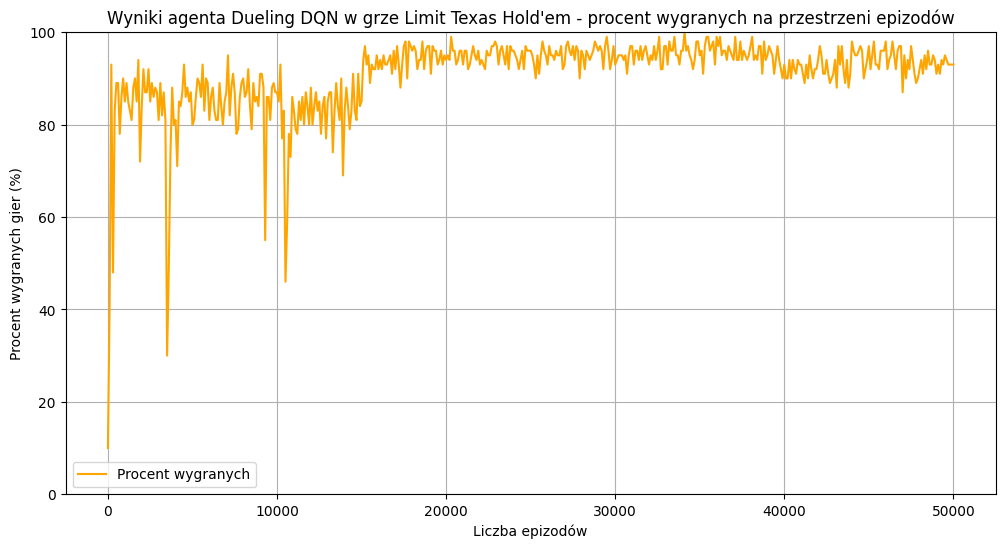

In [ ]:
# uruchomienie pętli treningowej
training_loop(env_6, agent_6, 50000)

Zapisanie i wczytanie modelu


In [ ]:
# zapisanie modelu do pliku zewnętrznego
torch.save(agent_6.network.state_dict(), 'dueling_agent_6_model.pth')

In [ ]:
# wczytanie modelu z zewnętrznego pliku
agent_6.network.load_state_dict(torch.load('dueling_agent_6_model.pth'))

<ipython-input-64-bd1244be27d1>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  agent_3.network.load_state_dict(torch.load('dueling_agent_3_model.pth'))


<All keys matched successfully>

Test przeciwko agentowi_0

> agent_0 - zwycięzca z *agent_5* vs *agent_0*:
  - warstwy ukryte: **dwie warstwy po 64 neurony**
  - liczba epizodów: **10 tysięcy**
  - learning rate: **0.001**
  

In [ ]:
env6_test = rlcard.make('limit-holdem', config={'seed': 42})
env6_test.set_agents([agent_6, agent_0])

print("Test agent_6 vs agent_0")

experiment(env6_test)

Test agent_6 vs agent_0
Agent po rozegraniu 1000 gier uzyskał następujące wyniki:

Agent wygrał: 52.800000000000004% gier.
Średnia nagroda agenta na grę wyniosła: 1.387.


> Agent_6 wygrał 52.8% gier ze średnią nagrodą 1.387

### Wnioski ogólne ETAP I:

1. Agent_0 wykorzystujący sieć neuronową z dwóch warstw ukrytych po 64 neurony i z learning_rate wynoszącym 0.001, miał pozytywne win ratio na każdego innego agenta z większą liczbą neuronów w dwóch warstwach ukrytych i z mniejszym learning rate.

2. Po zmniejszeniu learning rate agentowi z dwoma warstwami ukrytymi w sieci neuronowej po 64 neurony z 0.001 na 0.0001, agent nadal jest gorszy niż agent_0.

3. Zwiększenie epizodów z 10 tysięcy do 50 tysięcy daje lepsze wyniki, jednak jest to bardzo kosztowne czasowo. Nauka agenta poprzez 50 tysięcy epizodów zajmuje około półtorej godziny, podczas gdy nauka agenta poprzez 10 tysięcy epizodów tylko około 15 minut.

## ETAP II - 3 warstwy

> - Znalezienie najlepszego agenta z trzema warstwami ukrytymi sieci neuronowej
- Sprawdzenie czy agent osiąga lepsze wyniki gdy jest trenowany na większej liczbie epizodów

### Eksperyment 2.1 - [64, 64, 64] vs Random
# ***Agent_7***
Dueling_DQN:
  - warstwy ukryte: **trzy warstwy po 64 neurony**
  - liczba epizodów: **10 tysięcy**
  - learning rate: **0.001**

Utworzenie środowiska i agentów

In [ ]:
# utworzenie środowiska
env_7 = rlcard.make('limit-holdem', config={'seed': 42})

# agent losowy do nauki
random_agent = RandomAgent(num_actions = env_7.num_actions)

# agent Dueling_DQN, który będzie się uczyć
agent_7 = Agent_DuelingDQN(state_size = env_7.state_shape[0][0], action_size = env_7.num_actions, layers = [64, 64, 64], lr = 0.001)

# ustawienie agentów w środowisku
env_7.set_agents([agent_7, random_agent])

# wypisanie agentów
print(f'Agenci: {env_7.agents}')

Agenci: [<__main__.Agent_DuelingDQN object at 0x7fcd3d77c250>, <rlcard.agents.random_agent.RandomAgent object at 0x7fcd3d77eaa0>]


Uruchomienie pętli treningowej

Epizod 0 zakończony. Win rate: 89.0%
Epizod 100 zakończony. Win rate: 25.0%
Epizod 200 zakończony. Win rate: 90.0%
Epizod 300 zakończony. Win rate: 93.0%
Epizod 400 zakończony. Win rate: 96.0%
Epizod 500 zakończony. Win rate: 90.0%
Epizod 600 zakończony. Win rate: 93.0%
Epizod 700 zakończony. Win rate: 93.0%
Epizod 800 zakończony. Win rate: 87.0%
Epizod 900 zakończony. Win rate: 92.0%
Epizod 1000 zakończony. Win rate: 93.0%
Epizod 1100 zakończony. Win rate: 96.0%
Epizod 1200 zakończony. Win rate: 88.0%
Epizod 1300 zakończony. Win rate: 88.0%
Epizod 1400 zakończony. Win rate: 99.0%
Epizod 1500 zakończony. Win rate: 98.0%
Epizod 1600 zakończony. Win rate: 96.0%
Epizod 1700 zakończony. Win rate: 98.0%
Epizod 1800 zakończony. Win rate: 93.0%
Epizod 1900 zakończony. Win rate: 95.0%
Epizod 2000 zakończony. Win rate: 98.0%
Epizod 2100 zakończony. Win rate: 94.0%
Epizod 2200 zakończony. Win rate: 97.0%
Epizod 2300 zakończony. Win rate: 95.0%
Epizod 2400 zakończony. Win rate: 98.0%
Epizod 2500 

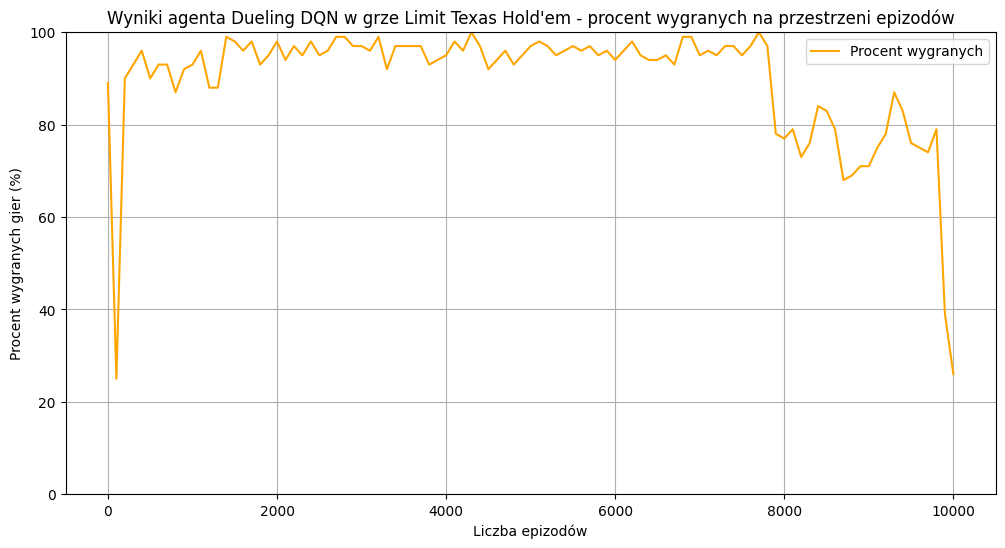

In [ ]:
# uruchomienie pętli treningowej
training_loop(env_7, agent_7, 10000)

Zapisanie i wczytanie modelu


In [ ]:
# zapisanie modelu do pliku zewnętrznego
torch.save(agent_7.network.state_dict(), 'dueling_agent_7_model.pth')

In [ ]:
# wczytanie modelu z zewnętrznego pliku
agent_7.network.load_state_dict(torch.load('dueling_agent_7_model.pth'))

<ipython-input-116-a627b2d2272a>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  agent_7.network.load_state_dict(torch.load('dueling_agent_7_model.pth'))


<All keys matched successfully>

Test przeciwko agentowi_0

> agent_0 - wygrany pojedynku agent_6 vs agent_0:
  - warstwy ukryte: dwie warstwy po 64 neurony
  - liczba epizodów: 10 tysięcy
  - learning rate: 0.001
  

In [ ]:
env7_test = rlcard.make('limit-holdem', config={'seed': 42})
env7_test.set_agents([agent_7, agent_0])

print("Test agent_7 vs agent_0")

experiment(env7_test)

Test agent_7 vs agent_0
Agent po rozegraniu 1000 gier uzyskał następujące wyniki:

Agent wygrał: 1.5% gier.
Średnia nagroda agenta na grę wyniosła: -0.8325.


> Agent_7 wygrał 1.5% gier ze średnią nagrodą -0.8325

### Eksperyment 2.2 - [128, 128, 128] vs Random
# ***Agent_8***
Dueling_DQN:
  - warstwy ukryte: **trzy warstwy po 128 neuronów**
  - liczba epizodów: **10 tysięcy**
  - learning rate: **0.001**

Utworzenie środowiska i agentów

In [ ]:
# utworzenie środowiska
env_8 = rlcard.make('limit-holdem', config={'seed': 42})

# agent losowy do nauki
random_agent = RandomAgent(num_actions = env_8.num_actions)

# agent Dueling_DQN, który będzie się uczyć
agent_8 = Agent_DuelingDQN(state_size = env_8.state_shape[0][0], action_size = env_8.num_actions, layers = [128, 128, 128], lr = 0.001)

# ustawienie agentów w środowisku
env_8.set_agents([agent_8, random_agent])

# wypisanie agentów
print(f'Agenci: {env_8.agents}')

Agenci: [<__main__.Agent_DuelingDQN object at 0x7fcd3d773370>, <rlcard.agents.random_agent.RandomAgent object at 0x7fcd3d773f70>]


Uruchomienie pętli treningowej

Epizod 0 zakończony. Win rate: 93.0%
Epizod 100 zakończony. Win rate: 88.0%
Epizod 200 zakończony. Win rate: 92.0%
Epizod 300 zakończony. Win rate: 96.0%
Epizod 400 zakończony. Win rate: 94.0%
Epizod 500 zakończony. Win rate: 87.0%
Epizod 600 zakończony. Win rate: 92.0%
Epizod 700 zakończony. Win rate: 91.0%
Epizod 800 zakończony. Win rate: 96.0%
Epizod 900 zakończony. Win rate: 92.0%
Epizod 1000 zakończony. Win rate: 95.0%
Epizod 1100 zakończony. Win rate: 92.0%
Epizod 1200 zakończony. Win rate: 96.0%
Epizod 1300 zakończony. Win rate: 96.0%
Epizod 1400 zakończony. Win rate: 98.0%
Epizod 1500 zakończony. Win rate: 96.0%
Epizod 1600 zakończony. Win rate: 97.0%
Epizod 1700 zakończony. Win rate: 97.0%
Epizod 1800 zakończony. Win rate: 96.0%
Epizod 1900 zakończony. Win rate: 95.0%
Epizod 2000 zakończony. Win rate: 96.0%
Epizod 2100 zakończony. Win rate: 96.0%
Epizod 2200 zakończony. Win rate: 93.0%
Epizod 2300 zakończony. Win rate: 96.0%
Epizod 2400 zakończony. Win rate: 95.0%
Epizod 2500 

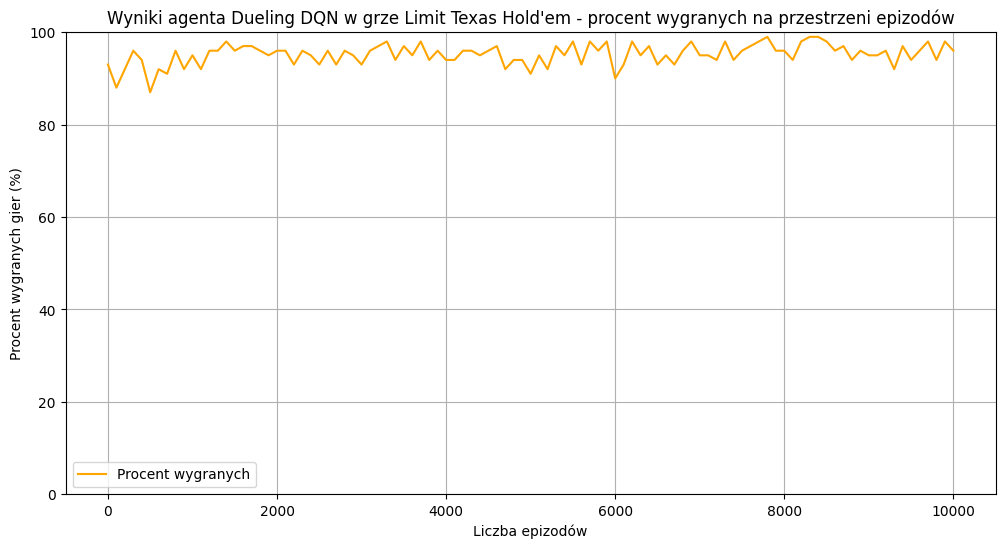

In [ ]:
# uruchomienie pętli treningowej
training_loop(env_8, agent_8, 10000)

Zapisanie i wczytanie modelu


In [ ]:
# zapisanie modelu do pliku zewnętrznego
torch.save(agent_8.network.state_dict(), 'dueling_agent_8_model.pth')

In [ ]:
# wczytanie modelu z zewnętrznego pliku
agent_8.network.load_state_dict(torch.load('dueling_agent_8_model.pth'))

<ipython-input-37-ae986a7c1eda>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  agent_1.network.load_state_dict(torch.load('dueling_agent_1_model.pth'))


<All keys matched successfully>

Test przeciwko agentowi_0

> agent_0 - wygrany pojedynku agent_7 vs agent_0:
  - warstwy ukryte: dwie warstwy po 64 neurony
  - liczba epizodów: 10 tysięcy
  - learning rate: 0.001
  

In [ ]:
env8_test = rlcard.make('limit-holdem', config={'seed': 42})
env8_test.set_agents([agent_8, agent_0])

print("Test agent_8 vs agent_0")

experiment(env8_test)

Test agent_8 vs agent_0
Agent po rozegraniu 1000 gier uzyskał następujące wyniki:

Agent wygrał: 31.8% gier.
Średnia nagroda agenta na grę wyniosła: -6.302.


> Agent_8 wygrał 31.8% gier ze średnią nagrodą -6.302

### Eksperyment 2.3 - [256, 256, 256] vs Random
# ***Agent_9***
Dueling_DQN:
  - warstwy ukryte: **trzy warstwy po 256 neuronów**
  - liczba epizodów: **10 tysięcy**
  - learning rate: **0.001**

Utworzenie środowiska i agentów

In [ ]:
# utworzenie środowiska
env_9 = rlcard.make('limit-holdem', config={'seed': 42})

# agent losowy do nauki
random_agent = RandomAgent(num_actions = env_9.num_actions)

# agent Dueling_DQN, który będzie się uczyć
agent_9 = Agent_DuelingDQN(state_size = env_9.state_shape[0][0], action_size = env_9.num_actions, layers = [256, 256, 256], lr = 0.001)

# ustawienie agentów w środowisku
env_9.set_agents([agent_9, random_agent])

# wypisanie agentów
print(f'Agenci: {env_9.agents}')

Agenci: [<__main__.Agent_DuelingDQN object at 0x7b1b4339fa90>, <rlcard.agents.random_agent.RandomAgent object at 0x7b1a6944d810>]


Uruchomienie pętli treningowej

Epizod 0 zakończony. Win rate: 81.0%
Epizod 100 zakończony. Win rate: 24.0%
Epizod 200 zakończony. Win rate: 44.0%
Epizod 300 zakończony. Win rate: 84.0%
Epizod 400 zakończony. Win rate: 78.0%
Epizod 500 zakończony. Win rate: 86.0%
Epizod 600 zakończony. Win rate: 79.0%
Epizod 700 zakończony. Win rate: 86.0%
Epizod 800 zakończony. Win rate: 83.0%
Epizod 900 zakończony. Win rate: 86.0%
Epizod 1000 zakończony. Win rate: 74.0%
Epizod 1100 zakończony. Win rate: 84.0%
Epizod 1200 zakończony. Win rate: 86.0%
Epizod 1300 zakończony. Win rate: 89.0%
Epizod 1400 zakończony. Win rate: 90.0%
Epizod 1500 zakończony. Win rate: 91.0%
Epizod 1600 zakończony. Win rate: 92.0%
Epizod 1700 zakończony. Win rate: 91.0%
Epizod 1800 zakończony. Win rate: 89.0%
Epizod 1900 zakończony. Win rate: 89.0%
Epizod 2000 zakończony. Win rate: 94.0%
Epizod 2100 zakończony. Win rate: 89.0%
Epizod 2200 zakończony. Win rate: 90.0%
Epizod 2300 zakończony. Win rate: 89.0%
Epizod 2400 zakończony. Win rate: 91.0%
Epizod 2500 

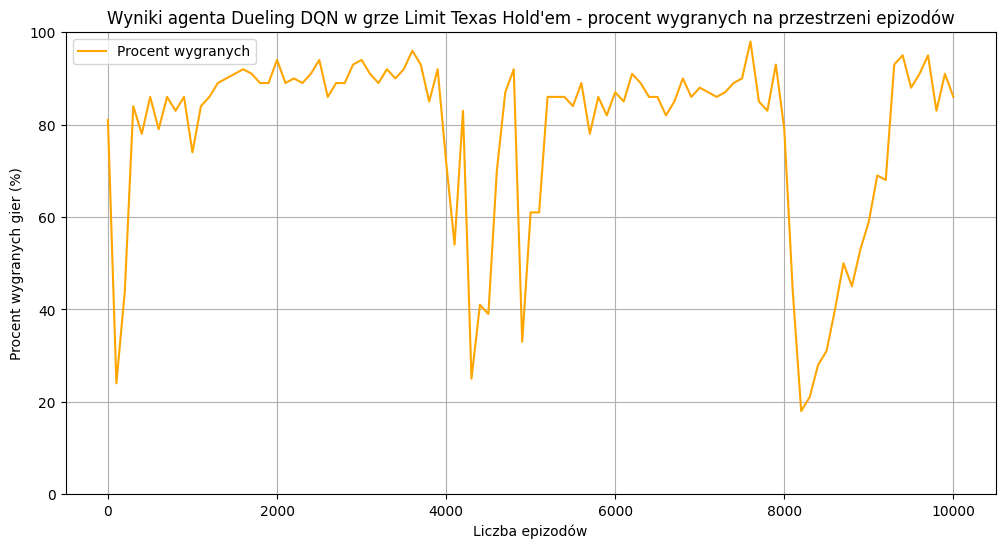

In [ ]:
# uruchomienie pętli treningowej
training_loop(env_9, agent_9, 10000)

Zapisanie i wczytanie modelu


In [ ]:
# zapisanie modelu do pliku zewnętrznego
torch.save(agent_9.network.state_dict(), 'dueling_agent_9_model.pth')

In [ ]:
# wczytanie modelu z zewnętrznego pliku
agent_9.network.load_state_dict(torch.load('dueling_agent_9_model.pth'))

<ipython-input-17-021a852f0ed8>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  agent_9.network.load_state_dict(torch.load('dueling_agent_9_model.pth'))


<All keys matched successfully>

Test przeciwko agentowi_0

> agent_0 - wygrany pojedynku agent_8 vs agent_0:
  - warstwy ukryte: dwie warstwy po 64 neurony
  - liczba epizodów: 10 tysięcy
  - learning rate: 0.001
  

In [ ]:
env9_test = rlcard.make('limit-holdem', config={'seed': 42})
env9_test.set_agents([agent_9, agent_0])

print("Test agent_9 vs agent_0")

experiment(env9_test)

Test agent_9 vs agent_0
Agent po rozegraniu 1000 gier uzyskał następujące wyniki:

Agent wygrał: 49.7% gier.
Średnia nagroda agenta na grę wyniosła: 0.117.


> Agent_9 wygrał 49.7% gier ze średnią nagrodą 0.117

### Eksperyment 2.4 - [512, 512, 512] vs Random
# ***Agent_10***
Dueling_DQN:
  - warstwy ukryte: **trzy warstwy po 512 neuronów**
  - liczba epizodów: **10 tysięcy**
  - learning rate: **0.001**

Utworzenie środowiska i agentów

In [ ]:
# utworzenie środowiska
env_10 = rlcard.make('limit-holdem', config={'seed': 42})

# agent losowy do nauki
random_agent = RandomAgent(num_actions = env_10.num_actions)

# agent Dueling_DQN, który będzie się uczyć
agent_10 = Agent_DuelingDQN(state_size = env_10.state_shape[0][0], action_size = env_10.num_actions, layers = [512, 512, 512], lr = 0.001)

# ustawienie agentów w środowisku
env_10.set_agents([agent_10, random_agent])

# wypisanie agentów
print(f'Agenci: {env_10.agents}')

Agenci: [<__main__.Agent_DuelingDQN object at 0x7fcd45f89030>, <rlcard.agents.random_agent.RandomAgent object at 0x7fcd45f89750>]


Uruchomienie pętli treningowej

Epizod 0 zakończony. Win rate: 22.0%
Epizod 100 zakończony. Win rate: 19.0%
Epizod 200 zakończony. Win rate: 86.0%
Epizod 300 zakończony. Win rate: 88.0%
Epizod 400 zakończony. Win rate: 89.0%
Epizod 500 zakończony. Win rate: 90.0%
Epizod 600 zakończony. Win rate: 96.0%
Epizod 700 zakończony. Win rate: 94.0%
Epizod 800 zakończony. Win rate: 89.0%
Epizod 900 zakończony. Win rate: 94.0%
Epizod 1000 zakończony. Win rate: 96.0%
Epizod 1100 zakończony. Win rate: 98.0%
Epizod 1200 zakończony. Win rate: 91.0%
Epizod 1300 zakończony. Win rate: 91.0%
Epizod 1400 zakończony. Win rate: 95.0%
Epizod 1500 zakończony. Win rate: 94.0%
Epizod 1600 zakończony. Win rate: 97.0%
Epizod 1700 zakończony. Win rate: 91.0%
Epizod 1800 zakończony. Win rate: 97.0%
Epizod 1900 zakończony. Win rate: 94.0%
Epizod 2000 zakończony. Win rate: 93.0%
Epizod 2100 zakończony. Win rate: 97.0%
Epizod 2200 zakończony. Win rate: 95.0%
Epizod 2300 zakończony. Win rate: 98.0%
Epizod 2400 zakończony. Win rate: 96.0%
Epizod 2500 

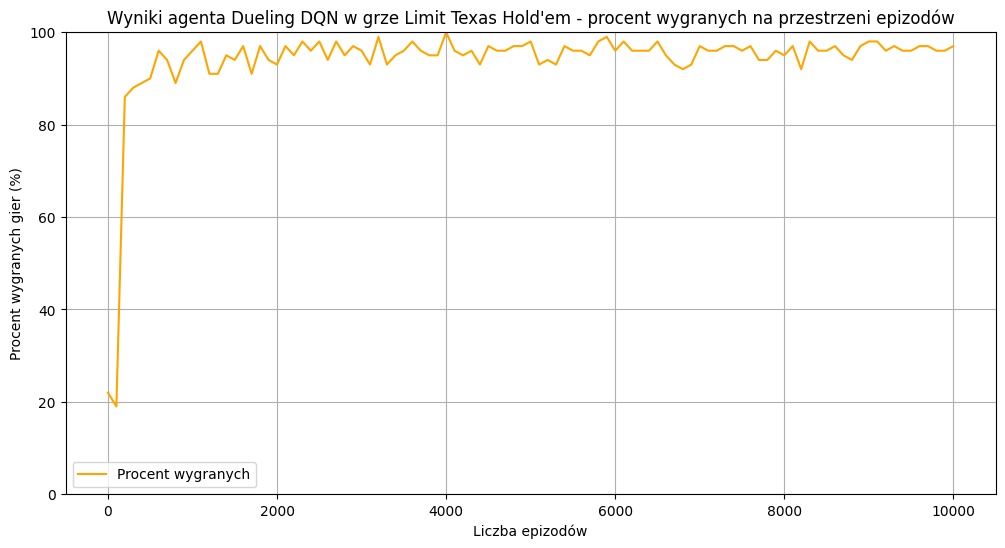

In [ ]:
# uruchomienie pętli treningowej
training_loop(env_10, agent_10, 10000)

Zapisanie i wczytanie modelu


In [ ]:
# zapisanie modelu do pliku zewnętrznego
torch.save(agent_10.network.state_dict(), 'dueling_agent_10_model.pth')

In [ ]:
# wczytanie modelu z zewnętrznego pliku
agent_10.network.load_state_dict(torch.load('dueling_agent_10_model.pth'))

<ipython-input-37-ae986a7c1eda>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  agent_1.network.load_state_dict(torch.load('dueling_agent_1_model.pth'))


<All keys matched successfully>

Test przeciwko agentowi_0

> agent_0 - wygrany pojedynku agent_9 vs agent_0:
  - warstwy ukryte: dwie warstwy po 64 neurony
  - liczba epizodów: 10 tysięcy
  - learning rate: 0.001
  

In [ ]:
env10_test = rlcard.make('limit-holdem', config={'seed': 42})
env10_test.set_agents([agent_10, agent_0])

print("Test agent_10 vs agent_0")

experiment(env10_test)

Test agent_10 vs agent_0
Agent po rozegraniu 1000 gier uzyskał następujące wyniki:

Agent wygrał: 33.4% gier.
Średnia nagroda agenta na grę wyniosła: -6.458.


Wniosek:
> Agent_10 wygrał 33.4% ze średnią nagrodą -6.458

### Eksperyment 2.5 - [256, 256, 256] vs Random
# ***Agent_11***
Dueling_DQN:
  - warstwy ukryte: **trzy warstwy po 256 neuronów**
  - liczba epizodów: **10 tysięcy**
  - learning rate: **0.0001**

Utworzenie środowiska i agentów

In [ ]:
# utworzenie środowiska
env_11 = rlcard.make('limit-holdem', config={'seed': 42})

# agent losowy do nauki
random_agent = RandomAgent(num_actions = env_11.num_actions)

# agent Dueling_DQN, który będzie się uczyć
agent_11 = Agent_DuelingDQN(state_size = env_11.state_shape[0][0], action_size = env_11.num_actions, layers = [256, 256, 256], lr = 0.0001)

# ustawienie agentów w środowisku
env_11.set_agents([agent_11, random_agent])

# wypisanie agentów
print(f'Agenci: {env_11.agents}')

Agenci: [<__main__.Agent_DuelingDQN object at 0x7c4fcfb7a110>, <rlcard.agents.random_agent.RandomAgent object at 0x7c4fcfdc0f10>]


Uruchomienie pętli treningowej

Epizod 0 zakończony. Win rate: 22.0%


<ipython-input-6-3d3d5e929d27>:54: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  states = torch.FloatTensor([s['obs'] for s in states])


Epizod 100 zakończony. Win rate: 91.0%
Epizod 200 zakończony. Win rate: 84.0%
Epizod 300 zakończony. Win rate: 98.0%
Epizod 400 zakończony. Win rate: 88.0%
Epizod 500 zakończony. Win rate: 94.0%
Epizod 600 zakończony. Win rate: 90.0%
Epizod 700 zakończony. Win rate: 94.0%
Epizod 800 zakończony. Win rate: 98.0%
Epizod 900 zakończony. Win rate: 87.0%
Epizod 1000 zakończony. Win rate: 95.0%
Epizod 1100 zakończony. Win rate: 94.0%
Epizod 1200 zakończony. Win rate: 92.0%
Epizod 1300 zakończony. Win rate: 92.0%
Epizod 1400 zakończony. Win rate: 98.0%
Epizod 1500 zakończony. Win rate: 96.0%
Epizod 1600 zakończony. Win rate: 95.0%
Epizod 1700 zakończony. Win rate: 94.0%
Epizod 1800 zakończony. Win rate: 95.0%
Epizod 1900 zakończony. Win rate: 92.0%
Epizod 2000 zakończony. Win rate: 95.0%
Epizod 2100 zakończony. Win rate: 97.0%
Epizod 2200 zakończony. Win rate: 99.0%
Epizod 2300 zakończony. Win rate: 98.0%
Epizod 2400 zakończony. Win rate: 96.0%
Epizod 2500 zakończony. Win rate: 94.0%
Epizod 26

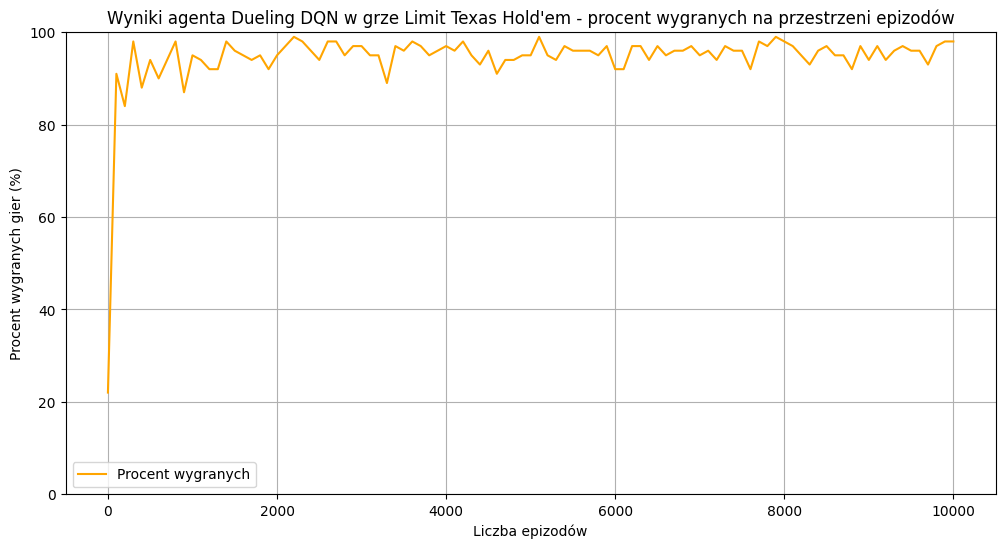

In [ ]:
# uruchomienie pętli treningowej
training_loop(env_11, agent_11, 10000)

Zapisanie i wczytanie modelu


In [ ]:
# zapisanie modelu do pliku zewnętrznego
torch.save(agent_11.network.state_dict(), 'dueling_agent_11_model.pth')

In [ ]:
# wczytanie modelu z zewnętrznego pliku
agent_11.network.load_state_dict(torch.load('dueling_agent_11_model.pth'))

<ipython-input-37-ae986a7c1eda>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  agent_1.network.load_state_dict(torch.load('dueling_agent_1_model.pth'))


<All keys matched successfully>

Test przeciwko agentowi_0

> agent_0 - wygrany pojedynku agent_9 vs agent_0:
  - warstwy ukryte: dwie warstwy po 64 neurony
  - liczba epizodów: 10 tysięcy
  - learning rate: 0.001
  

In [ ]:
env11_test = rlcard.make('limit-holdem', config={'seed': 42})
env11_test.set_agents([agent_11, agent_0])

print("Test agent_11 vs agent_0")

experiment(env11_test)

Test agent_11 vs agent_0
Agent po rozegraniu 1000 gier uzyskał następujące wyniki:

Agent wygrał: 42.5% gier.
Średnia nagroda agenta na grę wyniosła: -2.452.


> Agent_11 wygrał 42.5% gier ze średnią nagrodą -2.452

### Wnioski ogólne ETAP II:

1. Agent_0 wykorzystujący sieć neuronową z dwóch warstw ukrytych po 64 neurony i z learning_rate wynoszącym 0.001, nadal wygrywa z każdym agentem, nawet z tymi o większej ilości warstw sieci neuronowej.

2. Agent_9 osiągnął najlepsze wyniki przeciwko agentowi_0 przez co zostanie wykorzystany w innych eksperymentach jako agent z trzema warstwami ukrytmi [256, 256, 256].

3. Agent_9 po zmniejszeniu learning rate do 0.0001 nie osiąga lepszych wyników

## ETAP III - trenowanie na innych agentach

> - Przetrenowanie najlepszego agenta z Etapu I i najlepszego agenta z Etapu II przeciwko sobie
- porównanie wyników który jest lepszy
- porównanie czy agenci trenowani na innych agentach są lepsi niż agenci trenowani na agentach random

> Do testów zostaną wykorzystani *agenci*:
- Etap I: agent_0
  - warstwy: **dwie warstwy po 64 neurony**
  - learning rate: lr = 0.001
  - epizody: 10k
- Etap II: agent_9
  - warstwy: **trzy warstwy po 256 neuronów**
  - learning rate: lr = 0.001
  - epizody: 10k

### Eksperyment 3.1 - [64, 64] vs agent_0 [64, 64]
# ***Agent_12***
Dueling_DQN:
  - warstwy ukryte: **dwie warstwy po 64 neurony**
  - liczba epizodów: **10 tysięcy**
  - learning rate: **0.001**

Utworzenie środowiska i agentów

In [ ]:
# utworzenie środowiska
env_12 = rlcard.make('limit-holdem', config={'seed': 42})

# agent Dueling_DQN, który będzie się uczyć
agent_12 = Agent_DuelingDQN(state_size = env_12.state_shape[0][0], action_size = env_12.num_actions, layers = [64, 64], lr = 0.001)

# ustawienie agentów w środowisku
env_12.set_agents([agent_12, agent_0])

# wypisanie agentów
print(f'Agenci: {env_12.agents}')

Agenci: [<__main__.Agent_DuelingDQN object at 0x7aba3470d390>, <__main__.Agent_DuelingDQN object at 0x7aba5ef70b10>]


Uruchomienie pętli treningowej

Epizod 0 zakończony. Win rate: 0.0%
Epizod 100 zakończony. Win rate: 0.0%
Epizod 200 zakończony. Win rate: 0.0%
Epizod 300 zakończony. Win rate: 0.0%
Epizod 400 zakończony. Win rate: 8.0%
Epizod 500 zakończony. Win rate: 0.0%
Epizod 600 zakończony. Win rate: 4.0%
Epizod 700 zakończony. Win rate: 1.0%
Epizod 800 zakończony. Win rate: 5.0%
Epizod 900 zakończony. Win rate: 13.0%
Epizod 1000 zakończony. Win rate: 9.0%
Epizod 1100 zakończony. Win rate: 47.0%
Epizod 1200 zakończony. Win rate: 62.0%
Epizod 1300 zakończony. Win rate: 47.0%
Epizod 1400 zakończony. Win rate: 26.0%
Epizod 1500 zakończony. Win rate: 49.0%
Epizod 1600 zakończony. Win rate: 54.0%
Epizod 1700 zakończony. Win rate: 54.0%
Epizod 1800 zakończony. Win rate: 65.0%
Epizod 1900 zakończony. Win rate: 67.0%
Epizod 2000 zakończony. Win rate: 69.0%
Epizod 2100 zakończony. Win rate: 10.0%
Epizod 2200 zakończony. Win rate: 65.0%
Epizod 2300 zakończony. Win rate: 61.0%
Epizod 2400 zakończony. Win rate: 49.0%
Epizod 2500 zakończony

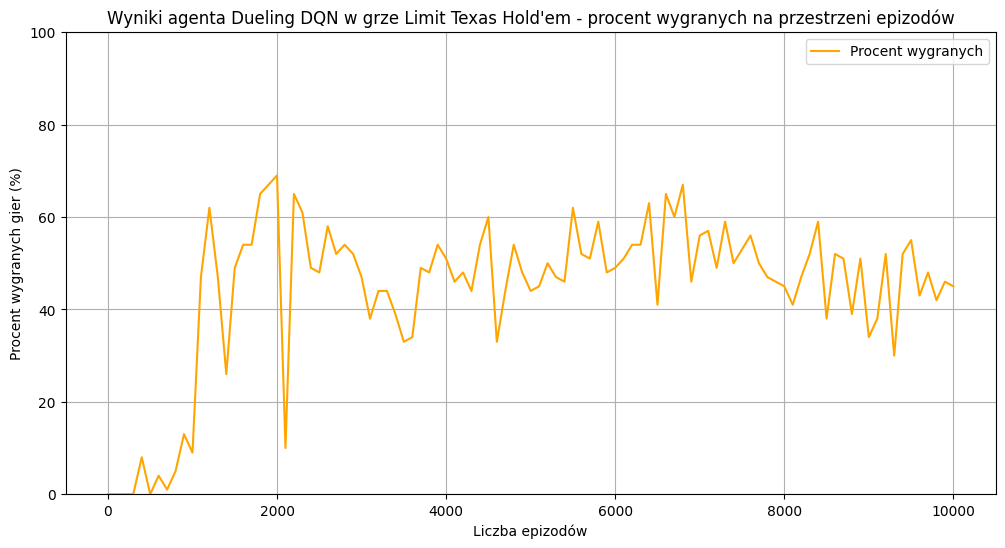

In [ ]:
# uruchomienie pętli treningowej
training_loop(env_12, agent_12, 10000)

Zapisanie i wczytanie modelu


In [ ]:
# zapisanie modelu do pliku zewnętrznego
torch.save(agent_12.network.state_dict(), 'dueling_agent_12_model.pth')

In [ ]:
# wczytanie modelu z zewnętrznego pliku
agent_12.network.load_state_dict(torch.load('dueling_agent_12_model.pth'))

<ipython-input-20-fc59e93a1df2>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  agent_12.network.load_state_dict(torch.load('dueling_agent_12_model.pth'))


<All keys matched successfully>

Test przeciwko agentowi_0

> agent_0 - najlepszy agent z Etapu I:
  - warstwy ukryte: dwie warstwy po 64 neurony
  - liczba epizodów: 10 tysięcy
  - learning rate: 0.001
  

In [ ]:
env12_test = rlcard.make('limit-holdem', config={'seed': 42})
env12_test.set_agents([agent_12, agent_0])

print("Test agent_12 vs agent_0")

experiment(env12_test)

Test agent_12 vs agent_0
Agent po rozegraniu 1000 gier uzyskał następujące wyniki:

Agent wygrał: 47.699999999999996% gier.
Średnia nagroda agenta na grę wyniosła: -0.7.


> Agent_12 wygrał 47.69% gier ze średnią nagrodą -0.7

### Eksperyment 3.2 - [256, 256, 256] vs agent_0 [64, 64]
# ***Agent_13***
Dueling_DQN:
  - warstwy ukryte: **trzy warstwy po 256 neuronów**
  - liczba epizodów: **10 tysięcy**
  - learning rate: **0.001**

Utworzenie środowiska i agentów

In [ ]:
# utworzenie środowiska
env_13 = rlcard.make('limit-holdem', config={'seed': 42})

# agent Dueling_DQN, który będzie się uczyć
agent_13 = Agent_DuelingDQN(state_size = env_13.state_shape[0][0], action_size = env_13.num_actions, layers = [256, 256, 256], lr = 0.001)

# ustawienie agentów w środowisku
env_13.set_agents([agent_13, agent_0])

# wypisanie agentów
print(f'Agenci: {env_13.agents}')

Agenci: [<__main__.Agent_DuelingDQN object at 0x7fd3d2ce4fd0>, <__main__.Agent_DuelingDQN object at 0x7fd3d3002ed0>]


Uruchomienie pętli treningowej

Epizod 0 zakończony. Win rate: 5.0%
Epizod 100 zakończony. Win rate: 5.0%
Epizod 200 zakończony. Win rate: 39.0%
Epizod 300 zakończony. Win rate: 19.0%
Epizod 400 zakończony. Win rate: 12.0%
Epizod 500 zakończony. Win rate: 18.0%
Epizod 600 zakończony. Win rate: 32.0%
Epizod 700 zakończony. Win rate: 35.0%
Epizod 800 zakończony. Win rate: 49.0%
Epizod 900 zakończony. Win rate: 49.0%
Epizod 1000 zakończony. Win rate: 60.0%
Epizod 1100 zakończony. Win rate: 62.0%
Epizod 1200 zakończony. Win rate: 49.0%
Epizod 1300 zakończony. Win rate: 44.0%
Epizod 1400 zakończony. Win rate: 46.0%
Epizod 1500 zakończony. Win rate: 52.0%
Epizod 1600 zakończony. Win rate: 44.0%
Epizod 1700 zakończony. Win rate: 55.00000000000001%
Epizod 1800 zakończony. Win rate: 41.0%
Epizod 1900 zakończony. Win rate: 43.0%
Epizod 2000 zakończony. Win rate: 55.00000000000001%
Epizod 2100 zakończony. Win rate: 56.99999999999999%
Epizod 2200 zakończony. Win rate: 50.0%
Epizod 2300 zakończony. Win rate: 40.0%
Epizod 2400 zak

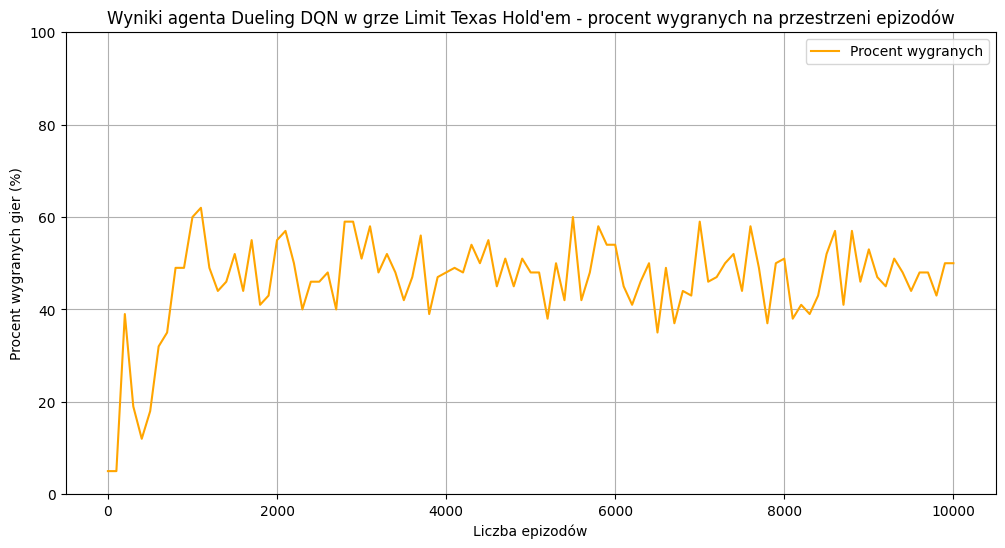

In [ ]:
# uruchomienie pętli treningowej
training_loop(env_13, agent_13, 10000)

Zapisanie i wczytanie modelu


In [ ]:
# zapisanie modelu do pliku zewnętrznego
torch.save(agent_13.network.state_dict(), 'dueling_agent_13_model.pth')

In [ ]:
# wczytanie modelu z zewnętrznego pliku
agent_13.network.load_state_dict(torch.load('dueling_agent_13_model.pth'))

<ipython-input-33-023a7903fc26>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  agent_13.network.load_state_dict(torch.load('dueling_agent_13_model.pth'))


<All keys matched successfully>

Test przeciwko agentowi_0

> agent_0 - najlepszy agent z Etapu I:
  - warstwy ukryte: dwie warstwy po 64 neurony
  - liczba epizodów: 10 tysięcy
  - learning rate: 0.001
  

In [ ]:
env13_test = rlcard.make('limit-holdem', config={'seed': 42})
env13_test.set_agents([agent_13, agent_0])

print("Test agent_13 vs agent_0")

experiment(env13_test)

Test agent_13 vs agent_0
Agent po rozegraniu 1000 gier uzyskał następujące wyniki:

Agent wygrał: 46.1% gier.
Średnia nagroda agenta na grę wyniosła: -0.871.


> Agent_13 wygrał 46.1% gier ze średnią nagrodą -0.871

### Eksperyment 3.3 - [256, 256, 256] vs agent_9 [256, 256, 256]
# ***Agent_14***
Dueling_DQN:
  - warstwy ukryte: **trzy warstwy po 256 neuronów**
  - liczba epizodów: **10 tysięcy**
  - learning rate: **0.001**

Utworzenie środowiska i agentów

In [ ]:
# utworzenie środowiska
env_14 = rlcard.make('limit-holdem', config={'seed': 42})

# agent Dueling_DQN, który będzie się uczyć
agent_14 = Agent_DuelingDQN(state_size = env_14.state_shape[0][0], action_size = env_14.num_actions, layers = [256, 256, 256], lr = 0.001)

# ustawienie agentów w środowisku
env_14.set_agents([agent_14, agent_9])

# wypisanie agentów
print(f'Agenci: {env_14.agents}')

Agenci: [<__main__.Agent_DuelingDQN object at 0x7fd3c9371750>, <__main__.Agent_DuelingDQN object at 0x7fd3d0eb1450>]


Uruchomienie pętli treningowej

Epizod 0 zakończony. Win rate: 18.0%


<ipython-input-6-3d3d5e929d27>:54: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  states = torch.FloatTensor([s['obs'] for s in states])


Epizod 100 zakończony. Win rate: 50.0%
Epizod 200 zakończony. Win rate: 40.0%
Epizod 300 zakończony. Win rate: 42.0%
Epizod 400 zakończony. Win rate: 43.0%
Epizod 500 zakończony. Win rate: 26.0%
Epizod 600 zakończony. Win rate: 34.0%
Epizod 700 zakończony. Win rate: 40.0%
Epizod 800 zakończony. Win rate: 40.0%
Epizod 900 zakończony. Win rate: 43.0%
Epizod 1000 zakończony. Win rate: 48.0%
Epizod 1100 zakończony. Win rate: 25.0%
Epizod 1200 zakończony. Win rate: 22.0%
Epizod 1300 zakończony. Win rate: 33.0%
Epizod 1400 zakończony. Win rate: 43.0%
Epizod 1500 zakończony. Win rate: 35.0%
Epizod 1600 zakończony. Win rate: 4.0%
Epizod 1700 zakończony. Win rate: 37.0%
Epizod 1800 zakończony. Win rate: 42.0%
Epizod 1900 zakończony. Win rate: 41.0%
Epizod 2000 zakończony. Win rate: 50.0%
Epizod 2100 zakończony. Win rate: 45.0%
Epizod 2200 zakończony. Win rate: 21.0%
Epizod 2300 zakończony. Win rate: 25.0%
Epizod 2400 zakończony. Win rate: 42.0%
Epizod 2500 zakończony. Win rate: 39.0%
Epizod 260

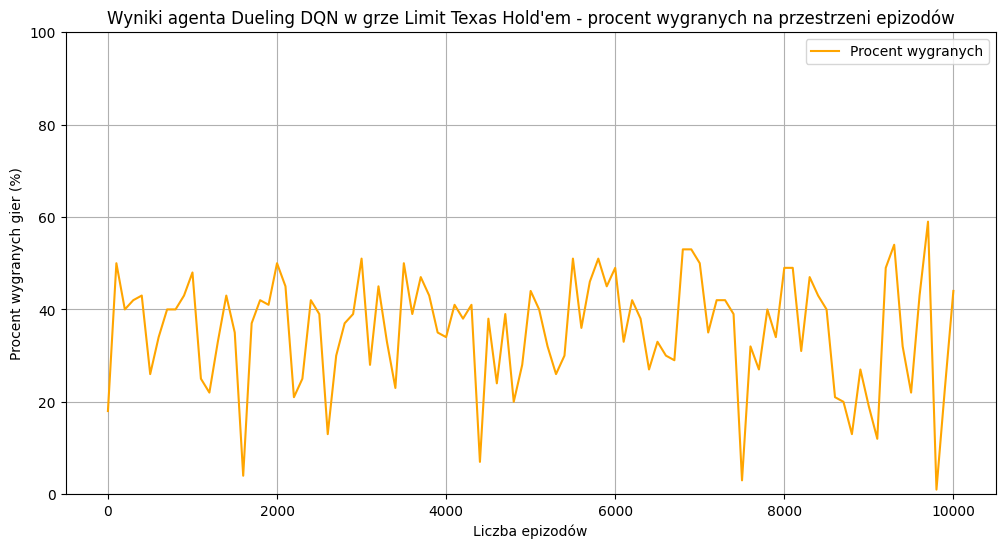

In [ ]:
# uruchomienie pętli treningowej
training_loop(env_14, agent_14, 10000)

Zapisanie i wczytanie modelu


In [ ]:
# zapisanie modelu do pliku zewnętrznego
torch.save(agent_14.network.state_dict(), 'dueling_agent_14_model.pth')

In [ ]:
# wczytanie modelu z zewnętrznego pliku
agent_14.network.load_state_dict(torch.load('dueling_agent_14_model.pth'))

<ipython-input-19-b00663eb8f05>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  agent_14.network.load_state_dict(torch.load('dueling_agent_14_model.pth'))


<All keys matched successfully>

Test przeciwko agentowi_0

> agent_0 - najlepszy agent z Etapu I:
  - warstwy ukryte: dwie warstwy po 64 neurony
  - liczba epizodów: 10 tysięcy
  - learning rate: 0.001
  

In [ ]:
env14_test = rlcard.make('limit-holdem', config={'seed': 42})
env14_test.set_agents([agent_14, agent_0])

print("Test agent_14 vs agent_0")

experiment(env14_test)

Test agent_14 vs agent_0
Agent po rozegraniu 1000 gier uzyskał następujące wyniki:

Agent wygrał: 12.2% gier.
Średnia nagroda agenta na grę wyniosła: -5.4475.


> Agent_14 wygrał 12.2% gier ze średnią nagrodą -5.4475

### Eksperyment 3.4 - [64, 64] vs agent_9 [256, 256, 256]
# ***Agent_15***
Dueling_DQN:
  - warstwy ukryte: **dwie warstwy po 64 neurony**
  - liczba epizodów: **10 tysięcy**
  - learning rate: **0.001**

Utworzenie środowiska i agentów

In [ ]:
# utworzenie środowiska
env_15 = rlcard.make('limit-holdem', config={'seed': 42})

# agent Dueling_DQN, który będzie się uczyć
agent_15 = Agent_DuelingDQN(state_size = env_15.state_shape[0][0], action_size = env_15.num_actions, layers = [64, 64], lr = 0.001)

# ustawienie agentów w środowisku
env_15.set_agents([agent_15, agent_9])

# wypisanie agentów
print(f'Agenci: {env_15.agents}')

Agenci: [<__main__.Agent_DuelingDQN object at 0x7fd3c6166dd0>, <__main__.Agent_DuelingDQN object at 0x7fd3d0eb1450>]


Uruchomienie pętli treningowej

Epizod 0 zakończony. Win rate: 0.0%
Epizod 100 zakończony. Win rate: 54.0%
Epizod 200 zakończony. Win rate: 52.0%
Epizod 300 zakończony. Win rate: 49.0%
Epizod 400 zakończony. Win rate: 54.0%
Epizod 500 zakończony. Win rate: 40.0%
Epizod 600 zakończony. Win rate: 52.0%
Epizod 700 zakończony. Win rate: 45.0%
Epizod 800 zakończony. Win rate: 48.0%
Epizod 900 zakończony. Win rate: 47.0%
Epizod 1000 zakończony. Win rate: 52.0%
Epizod 1100 zakończony. Win rate: 52.0%
Epizod 1200 zakończony. Win rate: 49.0%
Epizod 1300 zakończony. Win rate: 35.0%
Epizod 1400 zakończony. Win rate: 53.0%
Epizod 1500 zakończony. Win rate: 48.0%
Epizod 1600 zakończony. Win rate: 52.0%
Epizod 1700 zakończony. Win rate: 47.0%
Epizod 1800 zakończony. Win rate: 49.0%
Epizod 1900 zakończony. Win rate: 46.0%
Epizod 2000 zakończony. Win rate: 55.00000000000001%
Epizod 2100 zakończony. Win rate: 53.0%
Epizod 2200 zakończony. Win rate: 55.00000000000001%
Epizod 2300 zakończony. Win rate: 38.0%
Epizod 2400 zakończony. Win

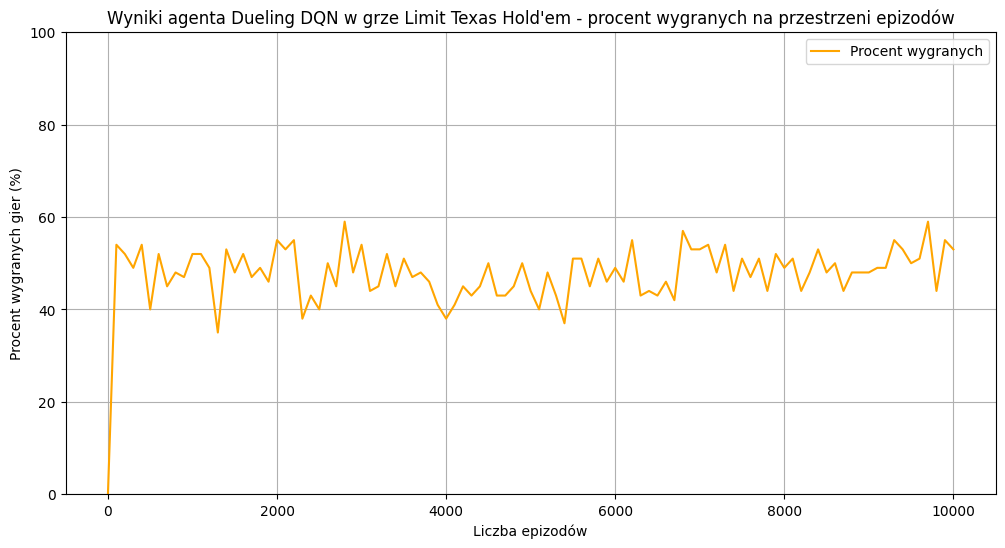

In [ ]:
# uruchomienie pętli treningowej
training_loop(env_15, agent_15, 10000)

Zapisanie i wczytanie modelu


In [ ]:
# zapisanie modelu do pliku zewnętrznego
torch.save(agent_15.network.state_dict(), 'dueling_agent_15_model.pth')

In [ ]:
# wczytanie modelu z zewnętrznego pliku
agent_15.network.load_state_dict(torch.load('dueling_agent_15_model.pth'))

<ipython-input-19-b00663eb8f05>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  agent_14.network.load_state_dict(torch.load('dueling_agent_14_model.pth'))


<All keys matched successfully>

Test przeciwko agentowi_0

> agent_0 - najlepszy agent z Etapu I:
  - warstwy ukryte: dwie warstwy po 64 neurony
  - liczba epizodów: 10 tysięcy
  - learning rate: 0.001
  

In [ ]:
env15_test = rlcard.make('limit-holdem', config={'seed': 42})
env15_test.set_agents([agent_15, agent_0])

print("Test agent_15 vs agent_0")

experiment(env15_test)

Test agent_15 vs agent_0
Agent po rozegraniu 1000 gier uzyskał następujące wyniki:

Agent wygrał: 37.9% gier.
Średnia nagroda agenta na grę wyniosła: -4.295.


> Agent_15 wygrał 37.9% gier ze średnią nagrodą -4.295

### Dodatkowy pojedynek I

# Agent_12 vs Agent_13

Agent_12 - dwie warstwy po 64 neurony trenowany na tym samym agencie (agent_0)

Agent_13 - trzy warstwy po 256 neuronów trenowany na tym samym agencie (agent_0)

In [ ]:
env_test_extra = rlcard.make('limit-holdem', config={'seed': 42})
env_test_extra.set_agents([agent_12, agent_13])

print("Test agent_12 vs agent_13")

experiment(env_test_extra)

Test agent_12 vs agent_13
Agent po rozegraniu 1000 gier uzyskał następujące wyniki:

Agent wygrał: 55.900000000000006% gier.
Średnia nagroda agenta na grę wyniosła: 2.719.


### Dodatkowy pojedynek II

# Agent_12 vs Agent_14

Agent_12 - dwie warstwy po 64 neurony trenowany na agencie_0 [64,64]

Agent_14 - trzy warstwy po 256 neuronów trenowany na agencie_9 [256,256,256]

In [ ]:
env_test_extra1 = rlcard.make('limit-holdem', config={'seed': 42})
env_test_extra1.set_agents([agent_12, agent_14])

print("Test agent_12 vs agent_14")

experiment(env_test_extra1)

Test agent_12 vs agent_14
Agent po rozegraniu 1000 gier uzyskał następujące wyniki:

Agent wygrał: 83.89999999999999% gier.
Średnia nagroda agenta na grę wyniosła: 4.41.


### Dodatkowy pojedynek III

# Agent_12 vs Agent_15

Agent_12 - dwie warstwy po 64 neurony trenowany na agencie_0 [64,64]

Agent_15 - dwie warstwy po 64 neurony trenowany na agencie_9 [256,256,256]

In [ ]:
env_test_extra2 = rlcard.make('limit-holdem', config={'seed': 42})
env_test_extra2.set_agents([agent_12, agent_15])

print("Test agent_12 vs agent_15")

experiment(env_test_extra2)

Test agent_12 vs agent_15
Agent po rozegraniu 1000 gier uzyskał następujące wyniki:

Agent wygrał: 65.9% gier.
Średnia nagroda agenta na grę wyniosła: 6.162.


### Wnioski ogólne ETAP III:

1. Agent_0 wykorzystujący sieć neuronową z dwóch warstw ukrytych po 64 neurony i z learning_rate wynoszącym 0.001, nadal wygrywa z każdym agentem.

2. Agenci uczeni na innych agentach nie osiągają dużo lepszych wyników od agentów uczonych na agencie random.

3. Żadnej agent nawet uczony na agencie_0 nie jest w stanie wygrać z dodatnim win ratio.

4. Agent korzystający z dwóch warstw po 64 neurony trenowany na agencie_0 także korzystającym z dwóch warstw ukrytych po 64 neurony, wygrywa z pozostałymi agentami z etapu III

## 7. Użycie biblioteki OpTuna do lepszego dobrania hiperparametrów sieci neuronowej

## ETAP IV

### 7.1 Importy

In [ ]:
import optuna

### 7.2 Funkcja celu

In [ ]:
def objective(trial):
  set_seed(42)
  learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
  num_hidden_layers = trial.suggest_int('num_hidden_layers', 2, 8)
  neurons_per_layer = trial.suggest_int('neurons_per_layer', 32, 512)

  mlp_layers = [neurons_per_layer] * num_hidden_layers

  env_opt = rlcard.make('limit-holdem', config={'seed': 42})

  agent_opt = Agent_DuelingDQN(
    state_size = env_opt.state_shape[0][0],
    action_size = env_opt.num_actions,
    layers = mlp_layers,
    lr = learning_rate)

  env_opt.set_agents([agent_opt, random_agent])

  num_of_episodes = 100 # Liczba epizodów do trenowania agenta
  percent_of_wins = []

  for episode in range(num_of_episodes + 1):
    state, _ = env_opt.reset()

    done = False
    while not done:
      action = agent_opt.step(state)
      next_state, reward = env_opt.step(action)
      done = env_opt.is_over()
      agent_opt.remember(state, action, reward, next_state, done)
      state = next_state

      agent_opt.train()

    if episode % 100 == 0:
      win_rate = testing(env_opt) * 100
      percent_of_wins.append(win_rate)

  return np.mean(percent_of_wins)


### 7.3 Uruchomienie OpTuny

In [ ]:
sampler = optuna.samplers.TPESampler(seed=42) # ustawienie ziarna losowiści dla reprodukowalności wyników
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=1000)

print(f"Najlepsze hiperparametry: {study.best_params}")
print(f"Najlepsza wartość celu: {study.best_value}")

[I 2025-01-22 19:17:52,979] A new study created in memory with name: no-name-9dfef264-8cb6-4c16-9cb1-9868d61d5c30
[I 2025-01-22 19:18:02,131] Trial 0 finished with value: 90.5 and parameters: {'learning_rate': 0.0001329291894316216, 'num_hidden_layers': 8, 'neurons_per_layer': 384}. Best is trial 0 with value: 90.5.
[I 2025-01-22 19:18:03,899] Trial 1 finished with value: 58.5 and parameters: {'learning_rate': 0.0006251373574521745, 'num_hidden_layers': 3, 'neurons_per_layer': 107}. Best is trial 0 with value: 90.5.
[I 2025-01-22 19:18:08,143] Trial 2 finished with value: 15.5 and parameters: {'learning_rate': 1.493656855461762e-05, 'num_hidden_layers': 8, 'neurons_per_layer': 321}. Best is trial 0 with value: 90.5.
[I 2025-01-22 19:18:12,443] Trial 3 finished with value: 65.0 and parameters: {'learning_rate': 0.001331121608073689, 'num_hidden_layers': 2, 'neurons_per_layer': 498}. Best is trial 0 with value: 90.5.
[I 2025-01-22 19:18:13,752] Trial 4 finished with value: 47.5 and param

Najlepsze hiperparametry: {'learning_rate': 0.00030632620661205764, 'num_hidden_layers': 7, 'neurons_per_layer': 357}
Najlepsza wartość celu: 94.0


### Wyświetlenie trzech najlepszych prób

In [ ]:
# Wyświetlenie 3 najlepszych prób
top_trials = sorted(study.trials, key=lambda t: t.value, reverse=True)[:3]

print("Najlepsze 3 zestawy hiperparametrów:")
for i, trial in enumerate(top_trials, start=1):
    print(f"\nMiejsce {i}:")
    print(f"  Hiperparametry: {trial.params}")
    print(f"  Wartość celu: {trial.value}")

NameError: name 'study' is not defined

### 7.4 Utworzenie agenta z najlepszymi parametrami wybranymi przez bibliotekę OpTuna

### Utworzenie hiperparametrów do przypisania

In [ ]:
best_params = study.best_params
best_learning_rate = best_params['learning_rate']
best_mlp_layers = [best_params['neurons_per_layer']] * best_params['num_hidden_layers']

training_config = []
for i, trial in enumerate(top_trials, start=1):
    params = trial.params
    config = {
        'learning_rate': params['learning_rate'],
        'mlp_layers': [params['neurons_per_layer']] * params['num_hidden_layers'],
    }
    training_config.append(config)

for i, config in enumerate(training_config, start=1):
    print(f"\nKonfiguracja {i}:")
    print(f"  Learning rate: {config['learning_rate']}")
    print(f"  Sieć neuronowa: {config['mlp_layers']}")


Konfiguracja 1:
  Learning rate: 0.00030632620661205764
  Sieć neuronowa: [357, 357, 357, 357, 357, 357, 357]

Konfiguracja 2:
  Learning rate: 0.006429751557141102
  Sieć neuronowa: [287, 287, 287, 287, 287, 287, 287]

Konfiguracja 3:
  Learning rate: 0.00031761007622629813
  Sieć neuronowa: [411, 411, 411, 411, 411, 411]


### Gotowe hiperparametry do późniejszych testów
### !! Uruchamiane tylko jeżeli nie odpalamy optuny wyżej !!

In [ ]:
training_config = []

config1 = {
        'learning_rate': 0.00030632620661205764,
        'mlp_layers': [357, 357, 357, 357, 357, 357, 357],
    }

training_config.append(config1)

config2 = {
        'learning_rate': 0.006429751557141102,
        'mlp_layers': [287, 287, 287, 287, 287, 287, 287],
    }

training_config.append(config2)

config3 = {
        'learning_rate': 0.00031761007622629813,
        'mlp_layers': [411, 411, 411, 411, 411, 411],
    }

training_config.append(config3)

for i, config in enumerate(training_config, start=1):
    print(f"\nKonfiguracja {i}:")
    print(f"  Learning rate: {config['learning_rate']}")
    print(f"  Sieć neuronowa: {config['mlp_layers']}")


Konfiguracja 1:
  Learning rate: 0.00030632620661205764
  Sieć neuronowa: [357, 357, 357, 357, 357, 357, 357]

Konfiguracja 2:
  Learning rate: 0.006429751557141102
  Sieć neuronowa: [287, 287, 287, 287, 287, 287, 287]

Konfiguracja 3:
  Learning rate: 0.00031761007622629813
  Sieć neuronowa: [411, 411, 411, 411, 411, 411]


## Utworzenie agenta OpTuna 1

In [ ]:
# utworzenie środowiska
env_test_optuna_1 = rlcard.make('limit-holdem', config={'seed': 42})

# agent losowy do nauki
random_agent = RandomAgent(num_actions = env_test_optuna_1.num_actions)

# agent Dueling_DQN, który będzie się uczyć
agent_optuna_1 = Agent_DuelingDQN(
    state_size = env_test_optuna_1.state_shape[0][0],
    action_size = env_test_optuna_1.num_actions,
    layers = training_config[0]['mlp_layers'],
    lr = training_config[0]['learning_rate'])

# ustawienie agentów w środowisku
env_test_optuna_1.set_agents([agent_optuna_1, random_agent])

# wypisanie agentów
print(f'Agenci: {env_test_optuna_1.agents}')

Agenci: [<__main__.Agent_DuelingDQN object at 0x7fd3c1b70a10>, <rlcard.agents.random_agent.RandomAgent object at 0x7fd3c24ce510>]


Epizod 0 zakończony. Win rate: 86.0%
Epizod 100 zakończony. Win rate: 22.0%
Epizod 200 zakończony. Win rate: 18.0%
Epizod 300 zakończony. Win rate: 82.0%
Epizod 400 zakończony. Win rate: 83.0%
Epizod 500 zakończony. Win rate: 85.0%
Epizod 600 zakończony. Win rate: 92.0%
Epizod 700 zakończony. Win rate: 93.0%
Epizod 800 zakończony. Win rate: 85.0%
Epizod 900 zakończony. Win rate: 98.0%
Epizod 1000 zakończony. Win rate: 90.0%
Epizod 1100 zakończony. Win rate: 91.0%
Epizod 1200 zakończony. Win rate: 93.0%
Epizod 1300 zakończony. Win rate: 95.0%
Epizod 1400 zakończony. Win rate: 97.0%
Epizod 1500 zakończony. Win rate: 97.0%
Epizod 1600 zakończony. Win rate: 96.0%
Epizod 1700 zakończony. Win rate: 95.0%
Epizod 1800 zakończony. Win rate: 95.0%
Epizod 1900 zakończony. Win rate: 93.0%
Epizod 2000 zakończony. Win rate: 96.0%
Epizod 2100 zakończony. Win rate: 97.0%
Epizod 2200 zakończony. Win rate: 94.0%
Epizod 2300 zakończony. Win rate: 96.0%
Epizod 2400 zakończony. Win rate: 93.0%
Epizod 2500 

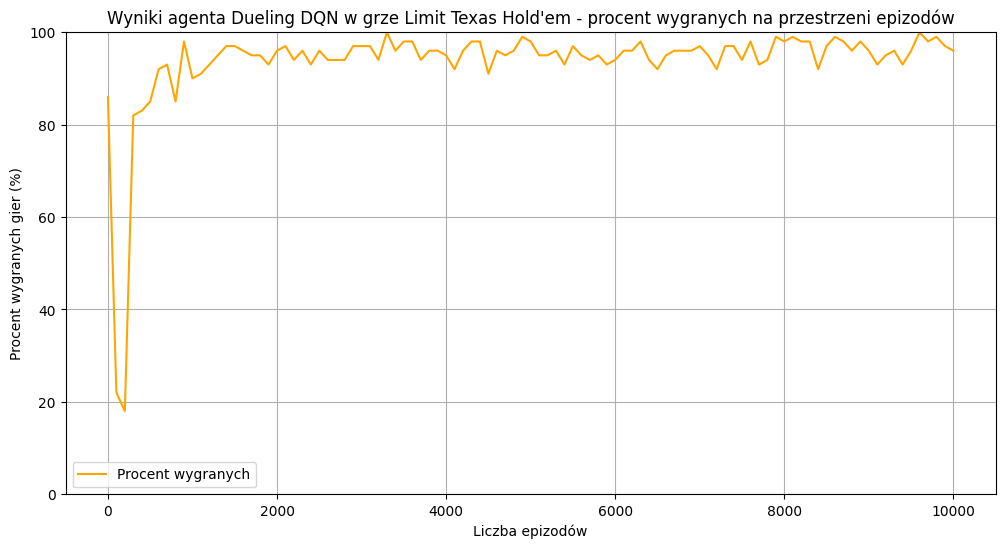

In [ ]:
# uruchomienie pętli treningowej
training_loop(env_test_optuna_1, agent_optuna_1, 10000)

###Zapis i wczytanie modelu

In [ ]:
# zapisanie modelu do pliku zewnętrznego
torch.save(agent_optuna_1.network.state_dict(), 'dueling_agent_optuna_1_model.pth')

In [ ]:
# wczytanie modelu z zewnętrznego pliku
agent_optuna_1.network.load_state_dict(torch.load('dueling_agent_optuna_1_model.pth'))

<ipython-input-19-72082a652def>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  agent_optuna.network.load_state_dict(torch.load('dueling_agent_optuna_model.pth'))


<All keys matched successfully>

### Testowanie agenta OpTuna 1

Test przeprowadzono z przeciwnikiem agentem_0 jako najlepszego agenta do tej pory.

> agent_optuna_1:
  - warstwy ukryte:
  - liczba epizodów: 10 tysięcy
  - learning rate:

> agent_0 - agent przykładowy:
  - warstwy ukryte: dwie warstwy po 64 neurony
  - liczba epizodów: 10 tysięcy
  - learning rate: 0.001

In [ ]:
envOpt_test_1 = rlcard.make('limit-holdem', config={'seed': 42})
envOpt_test_1.set_agents([agent_optuna_1, agent_0])

print("Test agent_optuna_1 vs agent_0")

experiment(envOpt_test_1)

Test agent_optuna_1 vs agent_0
Agent po rozegraniu 1000 gier uzyskał następujące wyniki:

Agent wygrał: 38.0% gier.
Średnia nagroda agenta na grę wyniosła: -4.482.


In [ ]:
envOpt_rand_test_1 = rlcard.make('limit-holdem', config={'seed': 42})

random_agent_opt = RandomAgent(num_actions = envOpt_rand_test_1.num_actions)

envOpt_rand_test_1.set_agents([agent_optuna_1, random_agent_opt])

print("Test agent_optuna vs random_agent")

experiment(envOpt_rand_test_1)

Test agent_optuna vs random_agent
Agent po rozegraniu 1000 gier uzyskał następujące wyniki:

Agent wygrał: 96.5% gier.
Średnia nagroda agenta na grę wyniosła: 2.6545.


> Agent_optuna_1 wygrał 38.0% gier ze średnią nagrodą -4.482

## Utworzenie agenta OpTuna 2

In [ ]:
print("Agent optuna 2")
print(f"Sieci neuronowe: {training_config[1]['mlp_layers']}")
print(f"Learning rate: {training_config[1]['learning_rate']}")

Agent optuna 2
Sieci neuronowe: [287, 287, 287, 287, 287, 287, 287]
Learning rate: 0.006429751557141102


In [ ]:
# utworzenie środowiska
env_test_optuna_2 = rlcard.make('limit-holdem', config={'seed': 42})

# agent losowy do nauki
random_agent_2 = RandomAgent(num_actions = env_test_optuna_2.num_actions)

# agent Dueling_DQN, który będzie się uczyć
agent_optuna_2 = Agent_DuelingDQN(
    state_size = env_test_optuna_2.state_shape[0][0],
    action_size = env_test_optuna_2.num_actions,
    layers = training_config[1]['mlp_layers'],
    lr = training_config[1]['learning_rate'])

# ustawienie agentów w środowisku
env_test_optuna_2.set_agents([agent_optuna_2, random_agent_2])

# wypisanie agentów
print(f'Agenci: {env_test_optuna_2.agents}')

Agenci: [<__main__.Agent_DuelingDQN object at 0x7910341817d0>, <rlcard.agents.random_agent.RandomAgent object at 0x79103419e290>]


Epizod 0 zakończony. Win rate: 90.0%


<ipython-input-6-3d3d5e929d27>:54: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  states = torch.FloatTensor([s['obs'] for s in states])


Epizod 100 zakończony. Win rate: 92.0%
Epizod 200 zakończony. Win rate: 94.0%
Epizod 300 zakończony. Win rate: 89.0%
Epizod 400 zakończony. Win rate: 90.0%
Epizod 500 zakończony. Win rate: 89.0%
Epizod 600 zakończony. Win rate: 96.0%
Epizod 700 zakończony. Win rate: 96.0%
Epizod 800 zakończony. Win rate: 88.0%
Epizod 900 zakończony. Win rate: 95.0%
Epizod 1000 zakończony. Win rate: 91.0%
Epizod 1100 zakończony. Win rate: 97.0%
Epizod 1200 zakończony. Win rate: 94.0%
Epizod 1300 zakończony. Win rate: 94.0%
Epizod 1400 zakończony. Win rate: 89.0%
Epizod 1500 zakończony. Win rate: 94.0%
Epizod 1600 zakończony. Win rate: 97.0%
Epizod 1700 zakończony. Win rate: 91.0%
Epizod 1800 zakończony. Win rate: 91.0%
Epizod 1900 zakończony. Win rate: 90.0%
Epizod 2000 zakończony. Win rate: 92.0%
Epizod 2100 zakończony. Win rate: 85.0%
Epizod 2200 zakończony. Win rate: 53.0%
Epizod 2300 zakończony. Win rate: 61.0%
Epizod 2400 zakończony. Win rate: 28.000000000000004%
Epizod 2500 zakończony. Win rate: 7

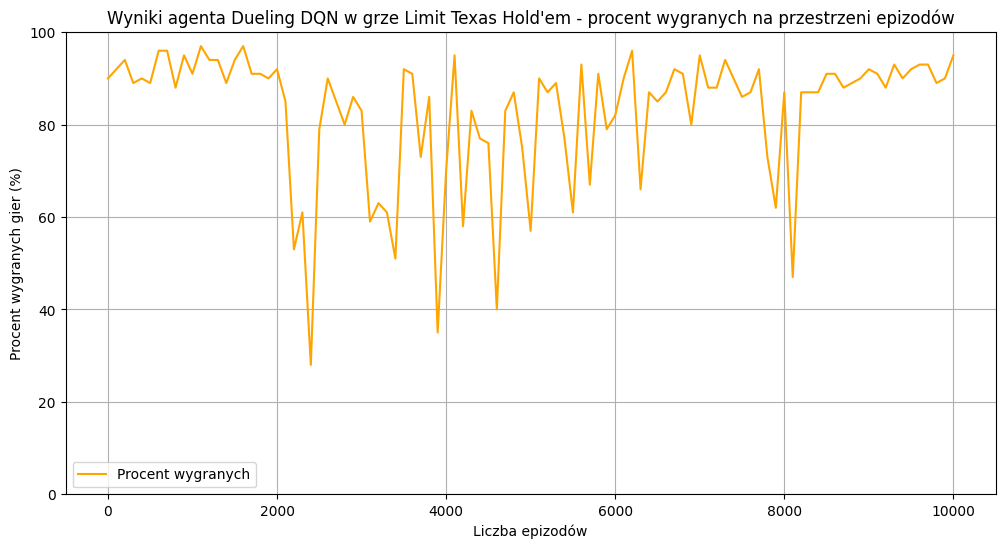

In [ ]:
# uruchomienie pętli treningowej
training_loop(env_test_optuna_2, agent_optuna_2, 10000)

###Zapis i wczytanie modelu

In [ ]:
# zapisanie modelu do pliku zewnętrznego
torch.save(agent_optuna_2.network.state_dict(), 'dueling_agent_optuna_2_model.pth')

In [ ]:
# wczytanie modelu z zewnętrznego pliku
agent_optuna_2.network.load_state_dict(torch.load('dueling_agent_optuna_2_model.pth'))

<ipython-input-19-bb947072ad27>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  agent_optuna_2.network.load_state_dict(torch.load('dueling_agent_optuna_2_model.pth'))


<All keys matched successfully>

### Testowanie agenta OpTuna 2

Test przeprowadzono z przeciwnikiem agentem_0 jako najlepszego agenta do tej pory.

> agent_optuna_2:
  - warstwy ukryte:
  - liczba epizodów: 10 tysięcy
  - learning rate:

> agent_0 - agent przykładowy:
  - warstwy ukryte: dwie warstwy po 64 neurony
  - liczba epizodów: 10 tysięcy
  - learning rate: 0.001

In [ ]:
envOpt_test_2 = rlcard.make('limit-holdem', config={'seed': 42})
envOpt_test_2.set_agents([agent_optuna_2, agent_0])

print("Test agent_optuna_2 vs agent_0")

experiment(envOpt_test_2)

Test agent_optuna_2 vs agent_0
Agent po rozegraniu 1000 gier uzyskał następujące wyniki:

Agent wygrał: 49.8% gier.
Średnia nagroda agenta na grę wyniosła: 0.131.


In [ ]:
envOpt_rand_test_2 = rlcard.make('limit-holdem', config={'seed': 42})

random_agent_opt_2 = RandomAgent(num_actions = envOpt_rand_test_2.num_actions)

envOpt_rand_test_2.set_agents([agent_optuna_2, random_agent_opt_2])

print("Test agent_optuna_2 vs random_agent")

experiment(envOpt_rand_test_2)

Test agent_optuna_2 vs random_agent
Agent po rozegraniu 1000 gier uzyskał następujące wyniki:

Agent wygrał: 89.60000000000001% gier.
Średnia nagroda agenta na grę wyniosła: 1.165.


> Agent_optuna_2 wygrał 49.8% gier ze średnią nagrodą 0.131

## Utworzenie agenta OpTuna 3

In [ ]:
print("Agent optuna 3")
print(f"Sieci neuronowe: {training_config[2]['mlp_layers']}")
print(f"Learning rate: {training_config[2]['learning_rate']}")

Agent optuna 3
Sieci neuronowe: [411, 411, 411, 411, 411, 411]
Learning rate: 0.00031761007622629813


In [ ]:
# utworzenie środowiska
env_test_optuna_3 = rlcard.make('limit-holdem', config={'seed': 42})

# agent losowy do nauki
random_agent_3 = RandomAgent(num_actions = env_test_optuna_3.num_actions)

# agent Dueling_DQN, który będzie się uczyć
agent_optuna_3 = Agent_DuelingDQN(
    state_size = env_test_optuna_3.state_shape[0][0],
    action_size = env_test_optuna_3.num_actions,
    layers = training_config[2]['mlp_layers'],
    lr = training_config[2]['learning_rate'])

# ustawienie agentów w środowisku
env_test_optuna_3.set_agents([agent_optuna_3, random_agent_3])

# wypisanie agentów
print(f'Agenci: {env_test_optuna_3.agents}')

Agenci: [<__main__.Agent_DuelingDQN object at 0x7b1b438b0b10>, <rlcard.agents.random_agent.RandomAgent object at 0x7b1b438b1610>]


Epizod 0 zakończony. Win rate: 90.0%


<ipython-input-6-3d3d5e929d27>:54: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  states = torch.FloatTensor([s['obs'] for s in states])


Epizod 100 zakończony. Win rate: 90.0%
Epizod 200 zakończony. Win rate: 41.0%
Epizod 300 zakończony. Win rate: 92.0%
Epizod 400 zakończony. Win rate: 88.0%
Epizod 500 zakończony. Win rate: 92.0%
Epizod 600 zakończony. Win rate: 86.0%
Epizod 700 zakończony. Win rate: 87.0%
Epizod 800 zakończony. Win rate: 89.0%
Epizod 900 zakończony. Win rate: 92.0%
Epizod 1000 zakończony. Win rate: 86.0%
Epizod 1100 zakończony. Win rate: 88.0%
Epizod 1200 zakończony. Win rate: 90.0%
Epizod 1300 zakończony. Win rate: 85.0%
Epizod 1400 zakończony. Win rate: 93.0%
Epizod 1500 zakończony. Win rate: 87.0%
Epizod 1600 zakończony. Win rate: 82.0%
Epizod 1700 zakończony. Win rate: 86.0%
Epizod 1800 zakończony. Win rate: 89.0%
Epizod 1900 zakończony. Win rate: 87.0%
Epizod 2000 zakończony. Win rate: 98.0%
Epizod 2100 zakończony. Win rate: 95.0%
Epizod 2200 zakończony. Win rate: 97.0%
Epizod 2300 zakończony. Win rate: 94.0%
Epizod 2400 zakończony. Win rate: 96.0%
Epizod 2500 zakończony. Win rate: 97.0%
Epizod 26

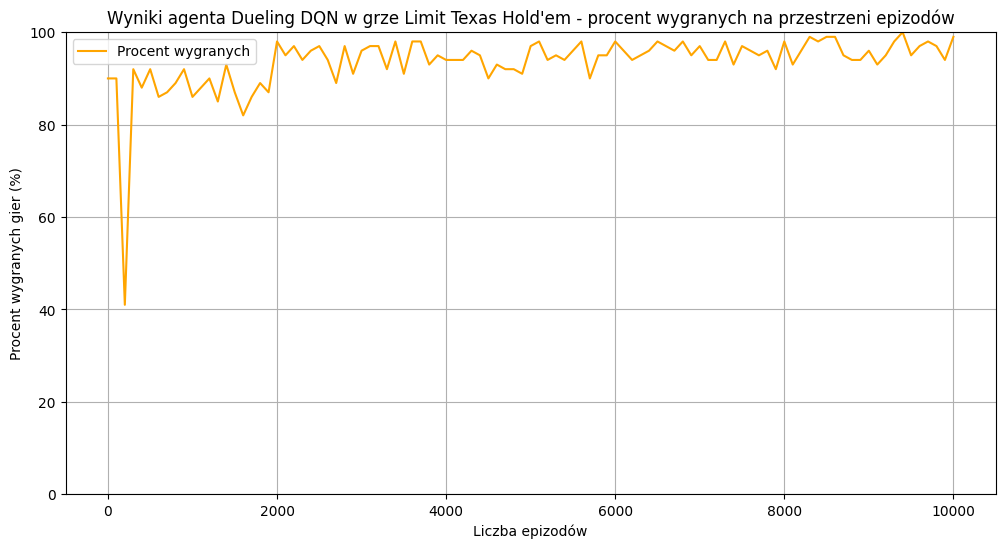

In [ ]:
# uruchomienie pętli treningowej
training_loop(env_test_optuna_3, agent_optuna_3, 10000)

###Zapis i wczytanie modelu

In [ ]:
# zapisanie modelu do pliku zewnętrznego
torch.save(agent_optuna_3.network.state_dict(), 'dueling_agent_optuna_3_model.pth')

In [ ]:
# wczytanie modelu z zewnętrznego pliku
agent_optuna_3.network.load_state_dict(torch.load('dueling_agent_optuna_3_model.pth'))

<ipython-input-22-1218f8c501e8>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  agent_optuna_3.network.load_state_dict(torch.load('dueling_agent_optuna_3_model.pth'))


<All keys matched successfully>

### Testowanie agenta OpTuna 3


Test przeprowadzono z przeciwnikiem agentem_0 jako najlepszego agenta do tej pory.

> agent_optuna_3:
  - warstwy ukryte:
  - liczba epizodów: 10 tysięcy
  - learning rate:

> agent_0 - agent przykładowy:
  - warstwy ukryte: dwie warstwy po 64 neurony
  - liczba epizodów: 10 tysięcy
  - learning rate: 0.001

In [ ]:
envOpt_test_3 = rlcard.make('limit-holdem', config={'seed': 42})
envOpt_test_3.set_agents([agent_optuna_3, agent_0])

print("Test agent_optuna_3 vs agent_0")

experiment(envOpt_test_3)

Test agent_optuna_3 vs agent_0
Agent po rozegraniu 1000 gier uzyskał następujące wyniki:

Agent wygrał: 49.8% gier.
Średnia nagroda agenta na grę wyniosła: 0.558.


In [ ]:
envOpt_rand_test_3 = rlcard.make('limit-holdem', config={'seed': 42})

random_agent_opt_3 = RandomAgent(num_actions = envOpt_rand_test_3.num_actions)

envOpt_rand_test_3.set_agents([agent_optuna_3, random_agent_opt_3])

print("Test agent_optuna_3 vs random_agent")

experiment(envOpt_rand_test_3)

Test agent_optuna_3 vs random_agent
Agent po rozegraniu 1000 gier uzyskał następujące wyniki:

Agent wygrał: 95.5% gier.
Średnia nagroda agenta na grę wyniosła: 2.5195.


> Agent_optuna_3 wygrał 49.8% gier ze średnią nagrodą 0.558

## ETAP V
## Testy przeciwko wbudowanemu agentowi DQN ze środowiska RLCard

## Utworzenie agenta DQN ze środowiska RLCard

Importy

In [ ]:
from rlcard.agents import DQNAgent

Utworzenie agenta i środowiska

In [ ]:
env_test_rlcard = rlcard.make('limit-holdem', config={'seed': 42})

random_agent_rlcard = RandomAgent(num_actions = env_test_rlcard.num_actions)

rlcard_agent_dqn = DQNAgent(num_actions = env_test_rlcard.num_actions,
                            state_shape = env_test_rlcard.state_shape[0][0],
                            mlp_layers = [64, 64])

env_test_rlcard.set_agents([rlcard_agent_dqn, random_agent_rlcard])

Trenowanie agenta

Epizod 0 zakończony. Win rate: 41.0%
INFO - Step 100, rl-loss: 1.8635966777801514
INFO - Copied model parameters to target network.
INFO - Step 277, rl-loss: 0.573527455329895Epizod 100 zakończony. Win rate: 54.0%
INFO - Step 572, rl-loss: 0.6488873362541199Epizod 200 zakończony. Win rate: 52.0%
INFO - Step 846, rl-loss: 0.39125755429267883Epizod 300 zakończony. Win rate: 53.0%
INFO - Step 1100, rl-loss: 0.19812174141407013
INFO - Copied model parameters to target network.
INFO - Step 1122, rl-loss: 0.6073419451713562Epizod 400 zakończony. Win rate: 54.0%
INFO - Step 1396, rl-loss: 0.4420382082462311Epizod 500 zakończony. Win rate: 69.0%
INFO - Step 1722, rl-loss: 0.36933937668800354Epizod 600 zakończony. Win rate: 72.0%
INFO - Step 2023, rl-loss: 0.2817610204219818Epizod 700 zakończony. Win rate: 80.0%
INFO - Step 2100, rl-loss: 0.3801509439945221
INFO - Copied model parameters to target network.
INFO - Step 2327, rl-loss: 0.30985450744628906Epizod 800 zakończony. Win rate: 82.0%
INFO

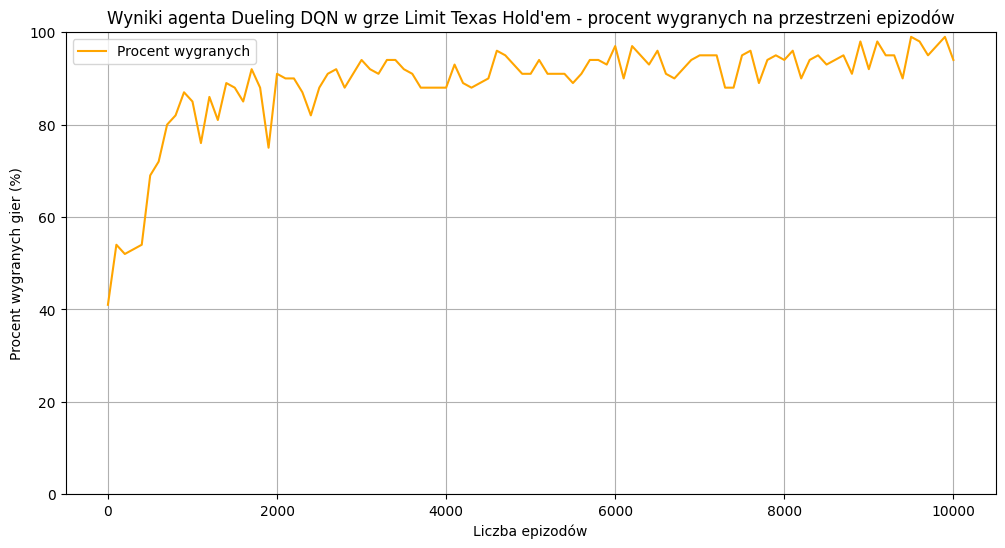

In [ ]:
set_seed(42)

num_of_episodes = 10000 # Liczba epizodów do trenowania agenta
percent_of_wins = []

for episode in range(num_of_episodes + 1):
    state, _ = env_test_rlcard.reset()

    done = False
    while not done:
        action = rlcard_agent_dqn.step(state)
        next_state, reward = env_test_rlcard.step(action)
        done = env_test_rlcard.is_over()
        rlcard_agent_dqn.feed((state, action, reward, next_state, done))
        state = next_state

        # rlcard_agent_dqn.train()

    if episode % 100 == 0:
        win_rate = testing(env_test_rlcard) * 100
        percent_of_wins.append(win_rate)
        print(f'Epizod {episode} zakończony. Win rate: {win_rate}%')

print('Trenowanie zakończone.\n')
diagram(percent_of_wins, num_of_episodes)

RLCard agent vs random_agent

In [ ]:
env_rlcard_test0 = rlcard.make('limit-holdem', config={'seed': 42})
env_rlcard_test0.set_agents([rlcard_agent_dqn, random_agent])

print("Test rlcard_agent_dqn vs random_agent")

experiment(env_rlcard_test0)

Test rlcard_agent_dqn vs random_agent
Agent po rozegraniu 1000 gier uzyskał następujące wyniki:

Agent wygrał: 95.3% gier.
Średnia nagroda agenta na grę wyniosła: 2.4175.


RLCard agent vs agent_0

In [ ]:
env_rlcard_test1 = rlcard.make('limit-holdem', config={'seed': 42})
env_rlcard_test1.set_agents([rlcard_agent_dqn, agent_0])

print("Test rlcard_agent_dqn vs agent_0")

experiment(env_rlcard_test1)

Test rlcard_agent_dqn vs agent_0
Agent po rozegraniu 1000 gier uzyskał następujące wyniki:

Agent wygrał: 68.30000000000001% gier.
Średnia nagroda agenta na grę wyniosła: 5.324.


RLCard agent vs agent_9

In [ ]:
env_rlcard_test2 = rlcard.make('limit-holdem', config={'seed': 42})
env_rlcard_test2.set_agents([rlcard_agent_dqn, agent_9])

print("Test rlcard_agent_dqn vs agent_9")

experiment(env_rlcard_test2)

Test rlcard_agent_dqn vs agent_9
Agent po rozegraniu 1000 gier uzyskał następujące wyniki:

Agent wygrał: 49.9% gier.
Średnia nagroda agenta na grę wyniosła: 0.237.


RLCard agent vs agent_12

In [ ]:
env_rlcard_test3 = rlcard.make('limit-holdem', config={'seed': 42})
env_rlcard_test3.set_agents([rlcard_agent_dqn, agent_12])

print("Test rlcard_agent_dqn vs agent_12")

experiment(env_rlcard_test3)

Test rlcard_agent_dqn vs agent_12
Agent po rozegraniu 1000 gier uzyskał następujące wyniki:

Agent wygrał: 64.60000000000001% gier.
Średnia nagroda agenta na grę wyniosła: 4.944.


RLCard agent vs agent_optuna_3

In [ ]:
env_rlcard_test4 = rlcard.make('limit-holdem', config={'seed': 42})
env_rlcard_test4.set_agents([rlcard_agent_dqn, agent_optuna_3])

print("Test rlcard_agent_dqn vs agent_optuna_3")

experiment(env_rlcard_test4)

Test rlcard_agent_dqn vs agent_optuna
Agent po rozegraniu 1000 gier uzyskał następujące wyniki:

Agent wygrał: 54.1% gier.
Średnia nagroda agenta na grę wyniosła: 1.706.


### Wnioski
>Najlepsi agenci to agent_9 oraz agent_optuna_3 którzy osiągają wyniki około 50% zwycięstw i zostaną przetestowani w dodatkowych testach sprawdzających ich skuteczność.

>Agenci agent_0 oraz agent_12 uzyskują zaledwie około 30% zwycięstw.

## Testy dodatkowe agentów agent_9 oraz agent_optuna_3
---
Testy wykonane w tym etapie są testami niereprodukowalnymi, a więc powtórzenia tych testów mogą się różnić od poprzedno przeprowadzonych testów


### Agent_9 vs RLCard_agent

In [ ]:
env_test_plus1_1 = rlcard.make('limit-holdem')
env_test_plus1_1.set_agents([agent_9, rlcard_agent_dqn])

print("Test agent_9 vs rlcard_agent_dqn")

experiment(env_test_plus1_1)

Test agent_9 vs rlcard_agent_dqn
Agent po rozegraniu 1000 gier uzyskał następujące wyniki:

Agent wygrał: 49.9% gier.
Średnia nagroda agenta na grę wyniosła: 0.175.


In [ ]:
env_test_plus1_2 = rlcard.make('limit-holdem')
env_test_plus1_2.set_agents([agent_9, rlcard_agent_dqn])

print("Test agent_9 vs rlcard_agent_dqn")

experiment(env_test_plus1_2)

Test agent_9 vs rlcard_agent_dqn
Agent po rozegraniu 1000 gier uzyskał następujące wyniki:

Agent wygrał: 50.0% gier.
Średnia nagroda agenta na grę wyniosła: 0.176.


In [ ]:
env_test_plus1_3 = rlcard.make('limit-holdem')
env_test_plus1_3.set_agents([agent_9, rlcard_agent_dqn])

print("Test agent_9 vs rlcard_agent_dqn")

experiment(env_test_plus1_3)

Test agent_9 vs rlcard_agent_dqn
Agent po rozegraniu 1000 gier uzyskał następujące wyniki:

Agent wygrał: 49.2% gier.
Średnia nagroda agenta na grę wyniosła: 0.167.


### Agent_optuna_3 vs RLCard_agent

In [ ]:
env_test_plus2_1 = rlcard.make('limit-holdem')
env_test_plus2_1.set_agents([agent_optuna_3, rlcard_agent_dqn])

print("Test agent_optuna_3 vs rlcard_agent_dqn")

experiment(env_test_plus2_1)

Test agent_optuna_3 vs rlcard_agent_dqn
Agent po rozegraniu 1000 gier uzyskał następujące wyniki:

Agent wygrał: 50.4% gier.
Średnia nagroda agenta na grę wyniosła: 0.744.


In [ ]:
env_test_plus2_2 = rlcard.make('limit-holdem')
env_test_plus2_2.set_agents([agent_optuna_3, rlcard_agent_dqn])

print("Test agent_optuna_3 vs rlcard_agent_dqn")

experiment(env_test_plus2_2)

Test agent_optuna_3 vs rlcard_agent_dqn
Agent po rozegraniu 1000 gier uzyskał następujące wyniki:

Agent wygrał: 48.699999999999996% gier.
Średnia nagroda agenta na grę wyniosła: 0.269.


In [ ]:
env_test_plus2_3 = rlcard.make('limit-holdem')
env_test_plus2_3.set_agents([agent_optuna_3, rlcard_agent_dqn])

print("Test agent_optuna_3 vs rlcard_agent_dqn")

experiment(env_test_plus2_3)

Test agent_optuna_3 vs rlcard_agent_dqn
Agent po rozegraniu 1000 gier uzyskał następujące wyniki:

Agent wygrał: 49.2% gier.
Średnia nagroda agenta na grę wyniosła: 0.099.


# Podsumowanie i wnioski

>Stworzony algorytm po odpowiednim dopasowaniu architektury sieci neuronowej może równać się z agentem DQN dostępnym w środowisku i wygrywać około połowę gier. Poker jest grą losową, zatem karty mogą nie układać się pomyślnie u gracza, a więc wynik 50% zwycięstw jest wynikiem ogólnie rzecz biorąc pozytywnym.

>Zatem algorytm Dueling DQN jest podobnie dobry co ten wbudowany w środowisku RLCard algorytm DQN.

# Symulacja gry
##**wirtualny agent vs człowiek**


## 1. Stworzenie agentów

### 1.1. Utworzenie agentów

In [ ]:
from rlcard.agents import LimitholdemHumanAgent as HumanAgent
from rlcard.utils import print_card

In [ ]:
env = rlcard.make('limit-holdem')

human_agent = HumanAgent(num_actions=env.num_actions)

###1.2. Ustawienie agentów

In [ ]:
env.set_agents([human_agent, agent_0])

number_of_players = 0
for agent in env.agents:
    print(f"Agent {number_of_players}: {agent}")
    number_of_players += 1
print(env.agents)

Agent 0: <rlcard.agents.human_agents.limit_holdem_human_agent.HumanAgent object at 0x7b1aa69e0210>
Agent 1: <__main__.Agent_DuelingDQN object at 0x7b1b289bc050>
[<rlcard.agents.human_agents.limit_holdem_human_agent.HumanAgent object at 0x7b1aa69e0210>, <__main__.Agent_DuelingDQN object at 0x7b1b289bc050>]


## 2. Zdefiniowane funkcji pozwalającej graczowi ludzkiemu wybrać akcje

### 2.1. Zdefiniowane funkcji pozwalającej graczowi ludzkiemu wybrać akcje

```
Funkcja pozwalająca graczowi ludzkiemu wybrać akcje.

:param state: Obecny stan gry
:return: Wybrana przez gracza akcja
```





In [ ]:
def human_agent_action(state):
    print("====== Twoje karty ======")
    print_card(state['raw_obs']['hand'])

    print("===== Karty wspólne =====")
    print_card(state['raw_obs']['public_cards'])
    print("=========================")

    legal_actions = list(state['legal_actions'].keys()) # Pobranie legalnych akcji na podstawie stanu gry
    print("Legalne akcje:")
    for action in legal_actions:
        print(f"{action}: {action_map[action]}")

    # Wyświetlanie liczb żetonów dla każdego gracza
    print("======== Żetony =========")
    total_chips = 0
    for i, chips in enumerate(state['raw_obs']['all_chips']):
        if i == 0:
            print(f"Ty : {chips} żetonów")
        else:
            print(f"Gracz {i}: {chips} żetonów")
        total_chips += chips
    print("\nŁączna liczba żetonów: ", total_chips)
    print("=========================\n")

    while True:
      try:
        action = int(input("Wybierz akcje: "))
        if action in legal_actions:
          return action
        else:
          print("Nieprawidłowy wybór. Spróbuj ponownie.")
      except:
        print("Prosze podać numer akcji.")

### 2.2. Ustawienie słownika dla ruchów

In [ ]:
action_map = {
    # 0: "call",       # Wejdź
    # 1: "raise",      # Podbij
    # 2: "fold",       # Pas
    # 3: "check",      # Czekaj

    0: "Wejdź",
    1: "Podbij",
    2: "Pas",
    3: "Czekaj"
}

## 3. Symulacja gry

### 3.1. Inicjalizacja gry

In [ ]:
state, player_id = env.reset()

### 3.2. Rozpoczęcie rozgrywki

In [ ]:
while not env.is_over():
    if player_id == 0:
        action = human_agent_action(state)
        next_player_id = 1
    else:
        action = env.agents[player_id].step(state)
        next_player_id = 0

    # Wykonanie akcji
    result = env.step(action)

    if len(result) == 4:
        state, reward, done, info = result
    elif len(result) == 2:
        state, reward = result
        done = False
        info = {}
    else:
        print("Niespodziewana liczba wartości zwrócona przez env.step")
        break

    # Wyświetlenie ruchów agentów
    if player_id == 0:
        print(f"\nWykonałeś ruch: {action_map[action]}\n")
    else:
        print(f"Gracz wykonał ruch: {action_map[action]}\n")

    player_id = next_player_id

    if done:
      break

# Po zakończeniu gry wyświetlenie kart agentów
print("====== Koniec gry =======")
print("====== Twoje karty ======")
print_card(env.get_perfect_information()['hand_cards'][0])

print("=== Karty przeciwnika ===")
print_card(env.get_perfect_information()['hand_cards'][1])

print("===== Karty wspólne =====")
print_card(state['raw_obs']['public_cards'])

# Wypisywanie wyników
print("=========================")
print("Wygrał gracz: ", reward, end="\n\n")

if reward == 0:
    print("Wygrałeś!")
    total_chips = 0
    for i, chips in enumerate(state['raw_obs']['all_chips']):
        total_chips += chips
    print("Łączna liczba wygranych żetonów: ", total_chips)
else:
    print("Przegrałeś!")
    total_chips = 0
    for i, chips in enumerate(state['raw_obs']['all_chips']):
        total_chips += chips
    print("Łączna liczba przegranych żetonów: ", total_chips)

Gracz wykonał ruch: Wejdź

====== Twoje karty ======
┌─────────┐   ┌─────────┐
│3        │   │10       │
│         │   │         │
│         │   │         │
│    ♦    │   │    ♠    │
│         │   │         │
│         │   │         │
│        3│   │       01│
└─────────┘   └─────────┘
===== Karty wspólne =====









Legalne akcje:
1: Podbij
2: Pas
3: Czekaj
======== Żetony =========
Ty : 2 żetonów
Gracz 1: 2 żetonów

Łączna liczba żetonów:  4

Wybierz akcje: 3

Wykonałeś ruch: Czekaj

Gracz wykonał ruch: Wejdź

====== Twoje karty ======
┌─────────┐   ┌─────────┐
│3        │   │10       │
│         │   │         │
│         │   │         │
│    ♦    │   │    ♠    │
│         │   │         │
│         │   │         │
│        3│   │       01│
└─────────┘   └─────────┘
===== Karty wspólne =====
┌─────────┐   ┌─────────┐   ┌─────────┐
│Q        │   │7        │   │4        │
│         │   │         │   │         │
│         │   │         │   │         │
│    ♥    │   │    ♦    │   │    